# Simulating hard spheres with Monte Carlo

Notebook written by [Manon Michel](manon.michel@uca.fr)

The goal here is to sample hard spheres systems. 

Hard spheres interact through an exclusion force, meaning that they cannot overlap. For a given diameter $\sigma>0$, the stationary probability distribution for of $N$ spheres in dimension $d$ in a square box of size $L$ with periodic boundaries has density with respect to the Lebesgue measure given by  $$\pi(x) = \prod_{i=1}^n\left( \prod_{k=1}^d\mathbb{1}(x_{i,k} >0)\mathbb{1}(x_{i,k} - L <0)\prod_{j<i} \mathbb{1}(||x_i-x_j||_2 - \sigma > 0) \right) \, .$$
Here $x \in \mathbb{R}^{d\times N}$ is a configuration of $N$ spheres at coordinates $x_i \in \mathbb{R}^d$ with $i \in \{1,\ldots,N\}$.

In [1]:
import numpy as np
import random, math
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 8

## 1) Two schemes for rejection sampling

We set $d=2$, $N=4$, $\sigma=1$ and $L=16$. 

> 1. Use the following code to generate 10000 configurations with both reject-sampling routines.
> 2. Plot the histograms of the interdistance between spheres (one plot) and of the x-coordinate and y-coordinate of the sphere positions (another plot) and compare both algorithms.
> 3. Plot the cumulative histograms of the interdistance between spheres (one plot) and of the x-coordinate and y-coordinate of the sphere positions (another plot) and compare both algorithms.

In [2]:
class periodic_hard_sphere:
    def __init__(self,N=4, d=2, sigma=1.0, L = 16):
        # Parameter initialization
        self.N = N #number of spheres
        self.d = d #dimension of box
        self.sigma = sigma #sphere diameter
        self.L = L #length of square box
    
    def get_periodic_distance(self, x_1,x_2):        
        delta_x = x_1-x_2
        diff_x_periodic = min(abs(delta_x[0]),self.L-abs(delta_x[0]))
        diff_y_periodic = min(abs(delta_x[1]),self.L-abs(delta_x[1]))
        d_sq = diff_x_periodic ** 2.0 + diff_y_periodic ** 2.0
        return d_sq**0.5
    
    def pair_overlap_check(self,x_1, x_2):
        d = self.get_periodic_distance(x_1,x_2)
        if d < self.sigma:
            return True  #There is an overlap          
        return False
    
    def generate_sphere_position(self):
        x_i_new = self.L * np.random.uniform(size=2) 
        return x_i_new
        
    def rejection_sampling_1(self):
        x = []
        while len(x) < self.N:
            overlapping_proposition = True
            while overlapping_proposition:
                x_i_new = self.generate_sphere_position()
                overlapping_proposition = False
                for x_j in x:
                    if self.pair_overlap_check(x_j,x_i_new):
                        overlapping_proposition = True
                        break
            x += [x_i_new]
        return x
    
       
    def rejection_sampling_2(self):                    
        x = []
        while  len(x) < self.N:
            while len(x) < self.N:
                x_i_new = self.generate_sphere_position()
                overlapping_proposition = False
                for x_j in x:
                    if self.pair_overlap_check(x_j,x_i_new):
                        overlapping_proposition = True
                        break
                if overlapping_proposition:
                    x = []
                    break
                x += [x_i_new]
        return x    
   

Exercise 1:


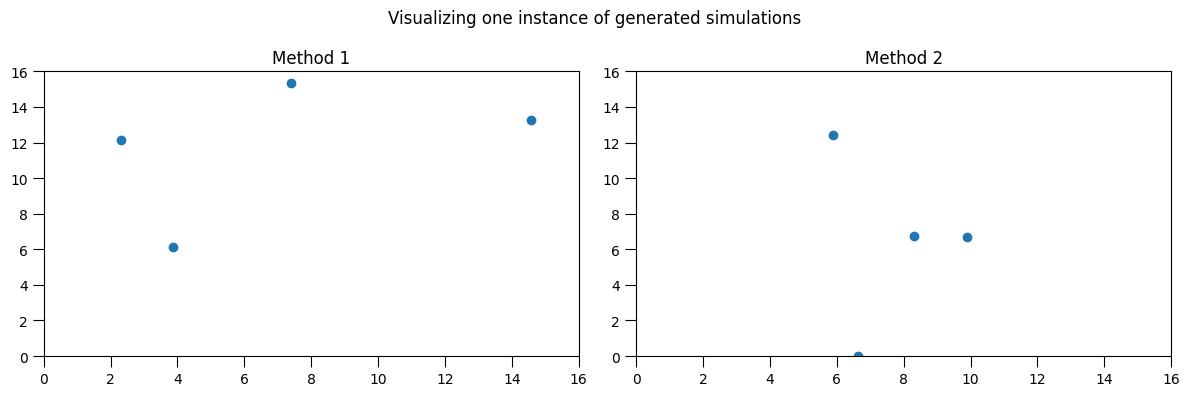

Exercise 2:


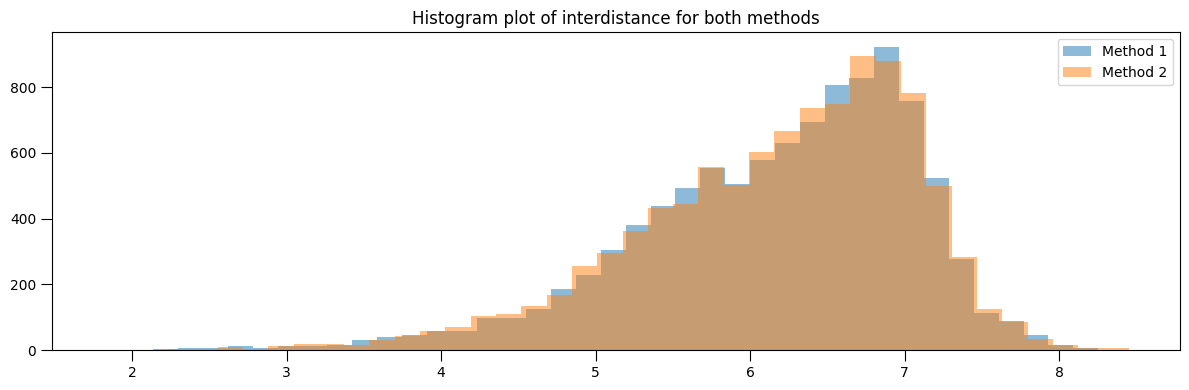

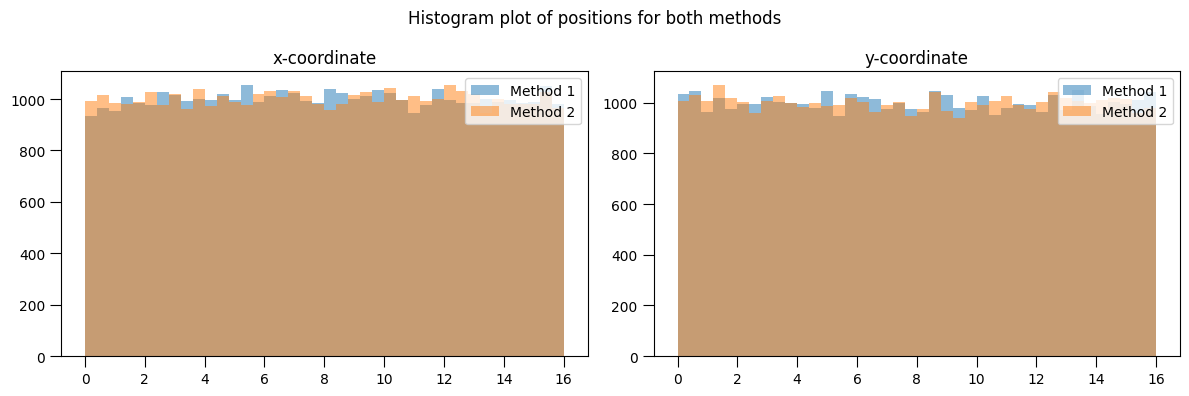

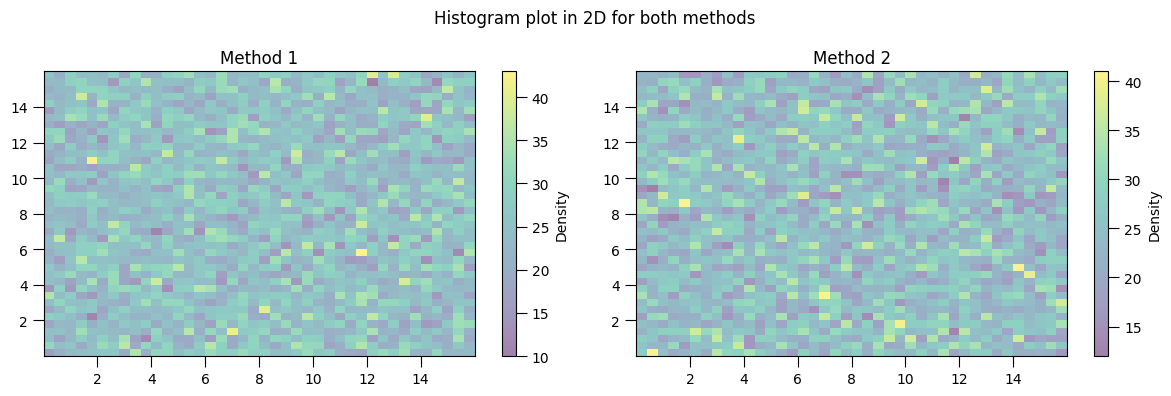

Exercise 3:


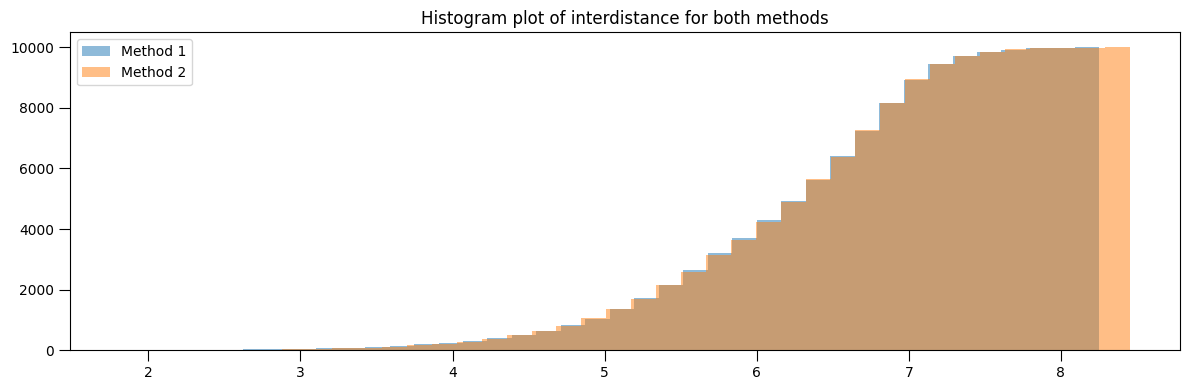

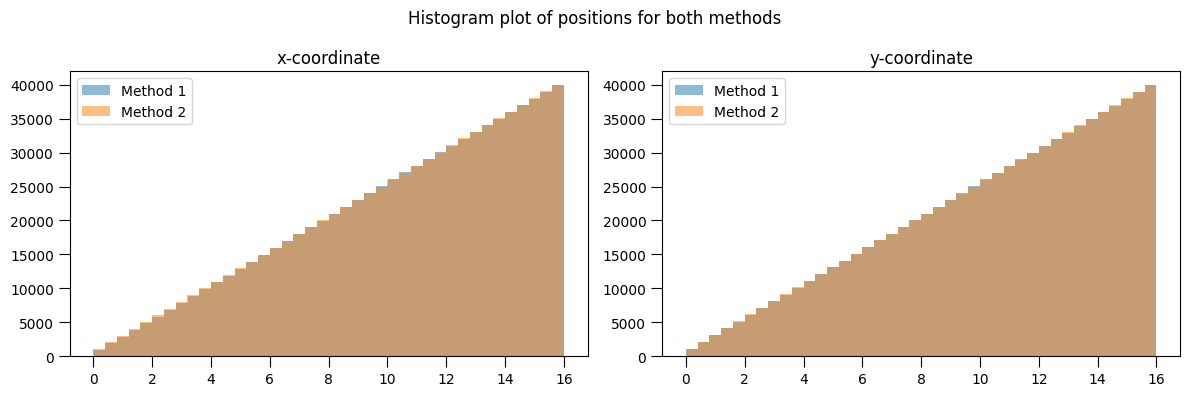

Extra plots:


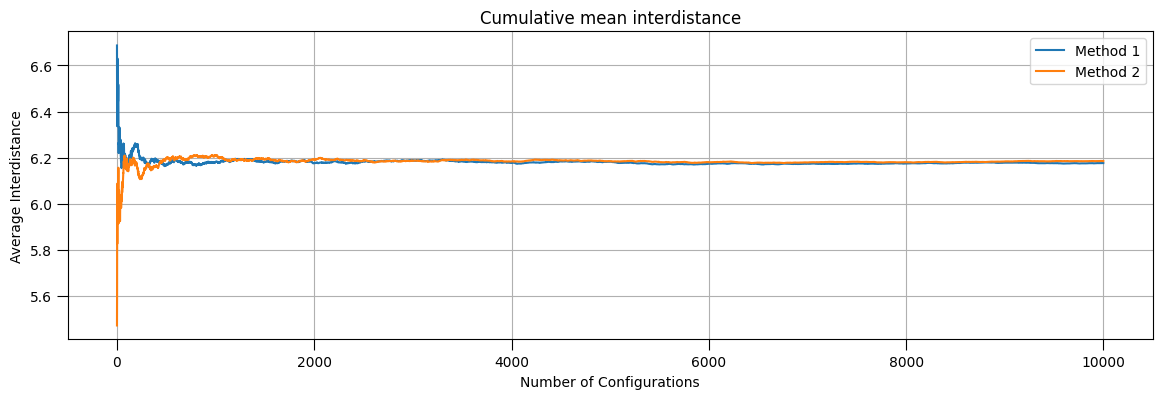

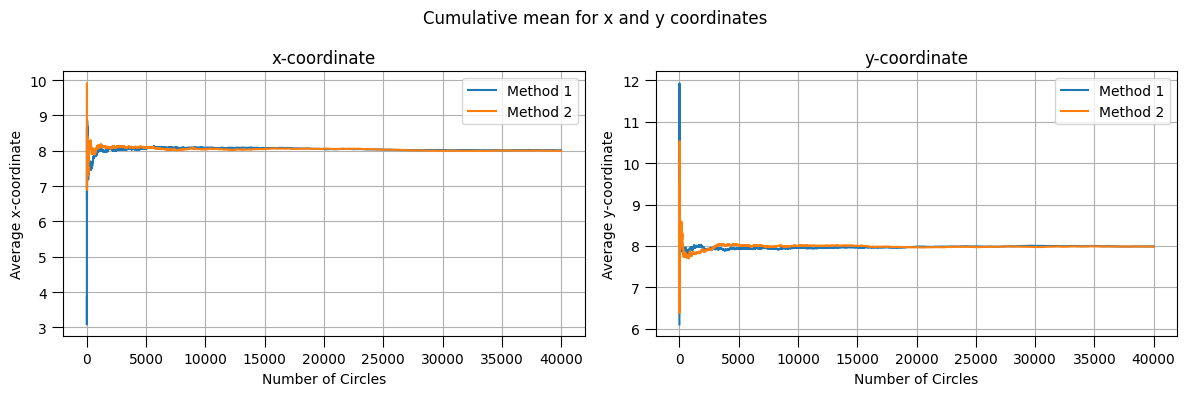

In [3]:
M = 10000
N = 4
d = 2

sigma = 1
L = 16

simulation = periodic_hard_sphere(N,d,sigma,L)

## Exercise 1
print("Exercise 1:")
# Generating configurations
configurations1 = np.zeros((M,N,d))
interdistance1 = np.zeros(M)

configurations2 = np.zeros((M,N,d))
interdistance2 = np.zeros(M)

for i in range(M):
    # Generating positions
    configurations1[i,:,:] = np.array(simulation.rejection_sampling_1())
    configurations2[i,:,:] = np.array(simulation.rejection_sampling_2())
    # Getting interdistances

    for j in range(N):
        for k in range(j):
            interdistance1[i] += simulation.get_periodic_distance(configurations1[i,j,:], configurations1[i,k,:])
            interdistance2[i] += simulation.get_periodic_distance(configurations2[i,j,:], configurations2[i,k,:])

    interdistance1[i] /= N * (N-1) / 2
    interdistance2[i] /= N * (N-1) / 2
    
# Visualizing one simulation
plt.figure(figsize=(12,4))
plt.suptitle("Visualizing one instance of generated simulations")

plt.subplot(1,2,1)
plt.title("Method 1")
x = configurations1[0,:,0]
y = configurations1[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.subplot(1,2,2)
plt.title("Method 2")
x = configurations2[0,:,0]
y = configurations2[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.tight_layout()
plt.show()

## Exercise 2
print("Exercise 2:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Method 1', alpha = 0.5, bins = 40)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 40)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Method 1', bins = 40)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 40)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Method 1', bins = 40)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 40)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram 2D plot
gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot in 2D for both methods")

plt.subplot(1,2,1)
plt.title("Method 1")
plt.hist2d(configurations1[:,:,0].flatten(), configurations1[:,:,1].flatten(), alpha = 0.5, bins = 40)
plt.colorbar().set_label('Density')

plt.subplot(1,2,2)
plt.title("Method 2")
plt.hist2d(configurations2[:,:,0].flatten(), configurations2[:,:,1].flatten(), alpha = 0.5, bins = 40)
plt.colorbar().set_label('Density')

plt.tight_layout()
plt.show()

## Exercise 3
print("Exercise 3:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Method 1', alpha = 0.5, bins = 40, cumulative=True)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 40, cumulative=True)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Method 1', bins = 40, cumulative = True)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 40, cumulative = True)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Method 1', bins = 40, cumulative = True)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 40, cumulative = True)
plt.legend()

plt.tight_layout()
plt.show()

# Extra plots
print("Extra plots:")

plt.figure(figsize=(14,4))
plt.title("Cumulative mean interdistance")
plt.plot(np.cumsum(interdistance1) / np.arange(1, M + 1), label='Method 1')
plt.plot(np.cumsum(interdistance2) / np.arange(1, M + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Configurations")
plt.ylabel("Average Interdistance")
plt.grid(True)
plt.show()

# Partial cumulative plot for x-coordinate and y-coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Cumulative mean for x and y coordinates")

plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.plot(np.cumsum(configurations1[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average x-coordinate")
plt.grid(True)

plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.plot(np.cumsum(configurations1[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average y-coordinate")
plt.grid(True)

plt.tight_layout()
plt.show()

Comments:

- **Exercise 2**: From the histogram plots of interdistance, x-coordinate, y-coordinate,  we can see that both methods generate a similar distributions. 
- **Exercise 3**: As for the cumulative plots, both seem to converge in the same pace towards the expected value of the interdistance, x-coordinate, and y-coordinate. 

We can see from the plots that both methods seem to generate simular results.

>  4. Do you have agreement betwee the two methods? 

Answer **Exercise 4**: From the plots obtained, both methods seem to agree. Method one consists of generating a circle until one fits in the configuration, while the second one tries to generate the whole set of circles, starting from scratch once a not permitted circle is generated. They should therefore generate valid configurations. It is important to note that the second method should take more time to execute since it is it restart an entire configuration once a bad circle appear instead of just generating a new circle as in the first mehtod.

> 5. Is the obtained histograms consistent with the expression of $\pi$?
> 6. Redo the experience with $L=3$. What happens?

Exercise 5 - Answer:

TODO

 Exercise 6.1:


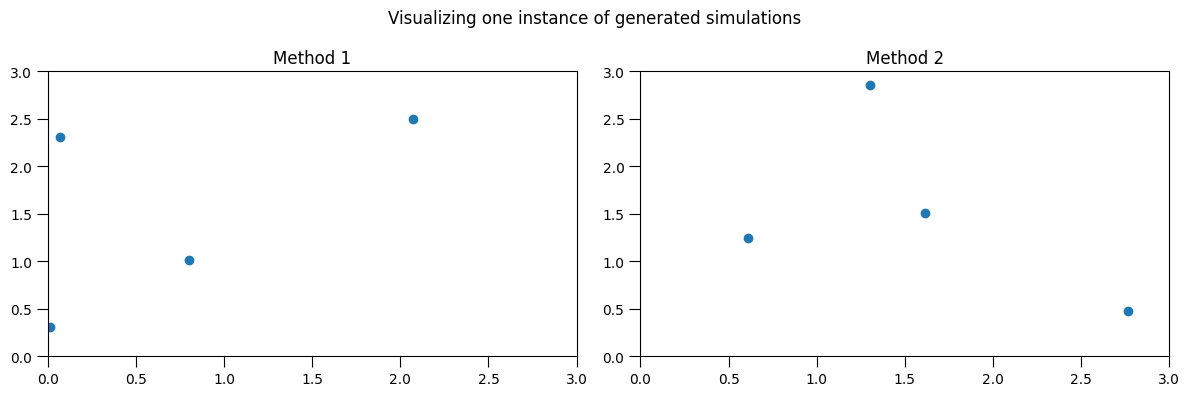

Exercise 6.2:


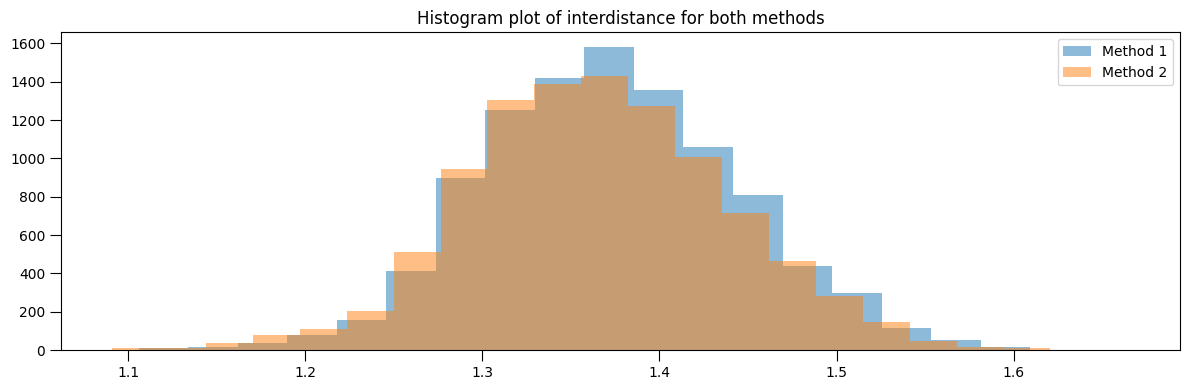

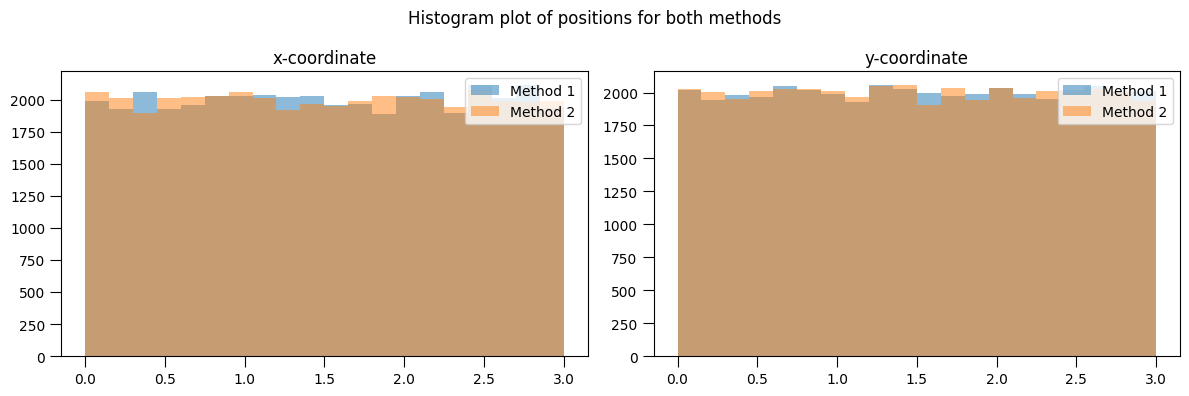

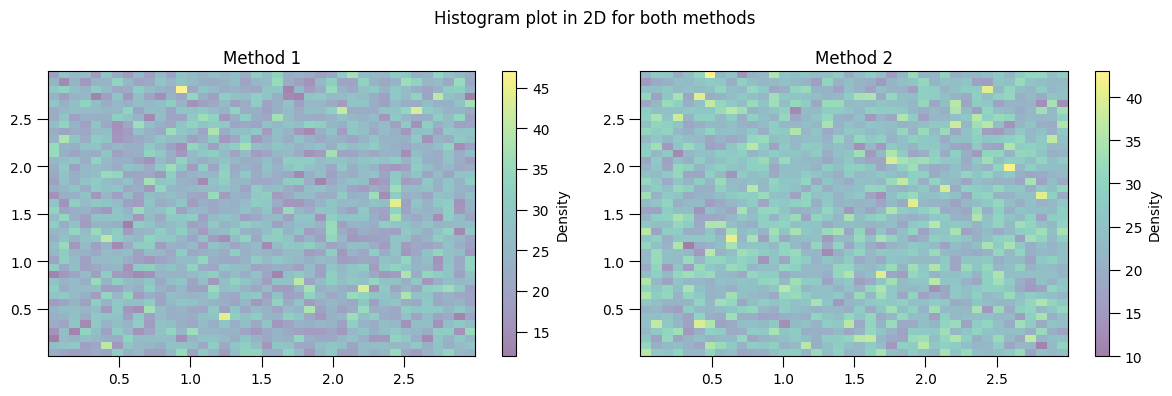

Exercise 6.3:


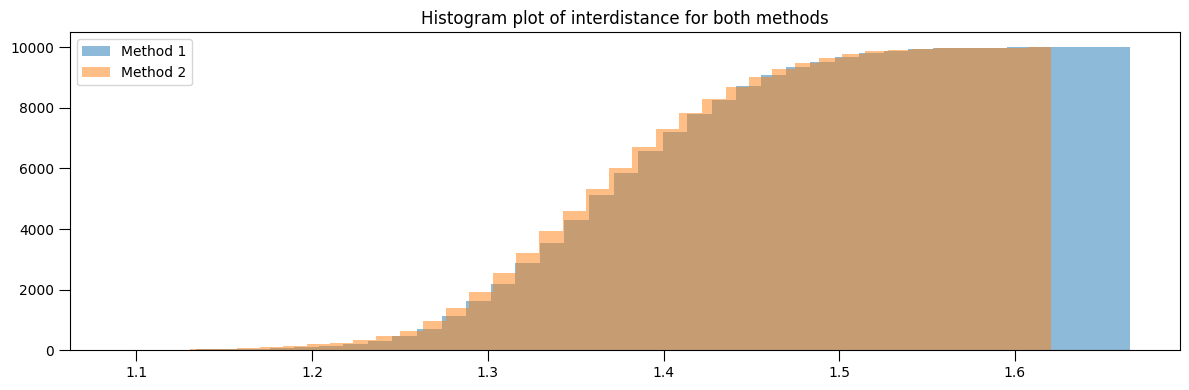

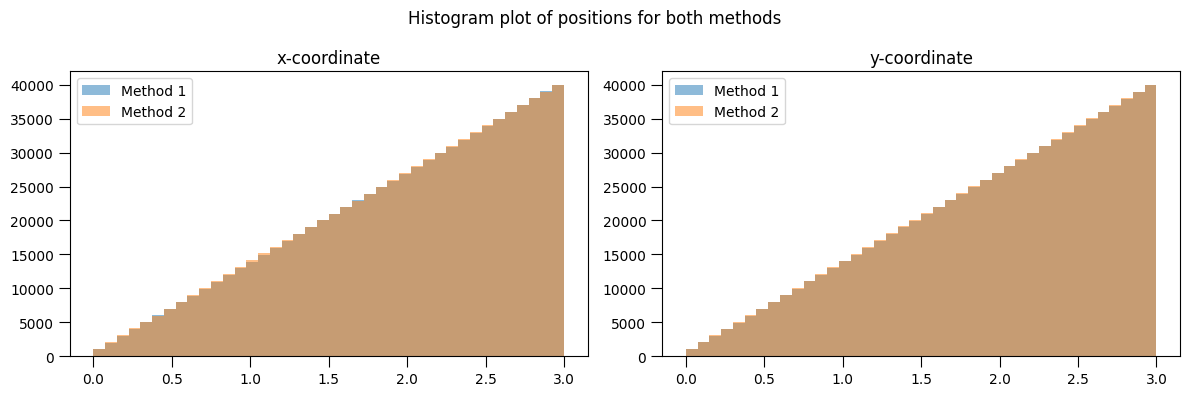

Extra plots:


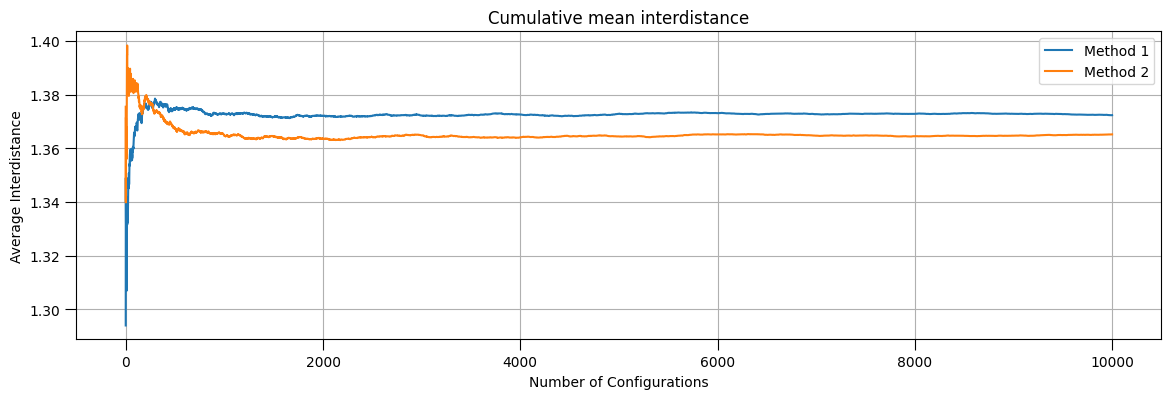

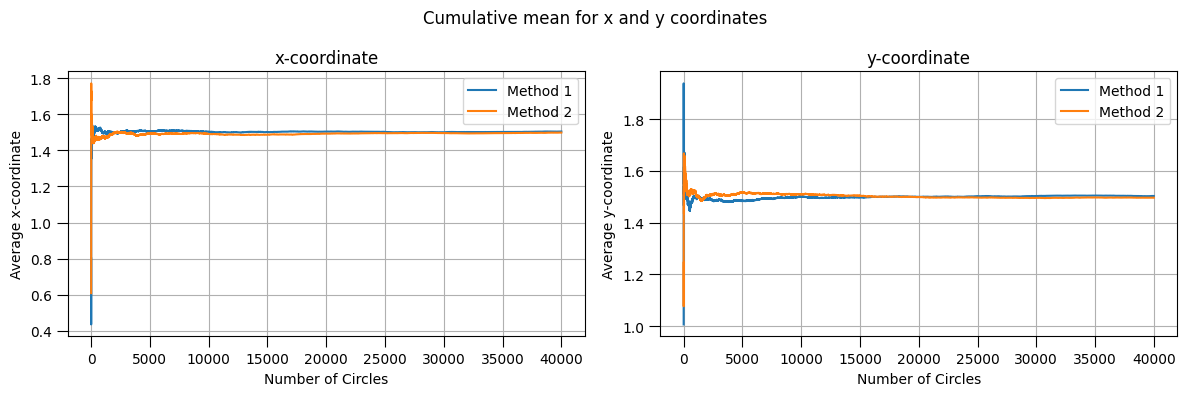

In [4]:
## Exercise 6 ##

M = 10000
N = 4
d = 2

sigma = 1
L = 3

simulation = periodic_hard_sphere(N,d,sigma,L)

## Plot similar to Exercise 6.1
print(" Exercise 6.1:")
# Generating configurations
configurations1 = np.zeros((M,N,d))
interdistance1 = np.zeros(M)

configurations2 = np.zeros((M,N,d))
interdistance2 = np.zeros(M)

for i in range(M):
    # Generating positions
    configurations1[i,:,:] = np.array(simulation.rejection_sampling_1())
    configurations2[i,:,:] = np.array(simulation.rejection_sampling_2())
    # Getting interdistances

    for j in range(N):
        for k in range(j):
            interdistance1[i] += simulation.get_periodic_distance(configurations1[i,j,:], configurations1[i,k,:])
            interdistance2[i] += simulation.get_periodic_distance(configurations2[i,j,:], configurations2[i,k,:])

    interdistance1[i] /= N * (N-1) / 2
    interdistance2[i] /= N * (N-1) / 2
    
# Visualizing one simulation
plt.figure(figsize=(12,4))
plt.suptitle("Visualizing one instance of generated simulations")

plt.subplot(1,2,1)
plt.title("Method 1")
x = configurations1[0,:,0]
y = configurations1[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.subplot(1,2,2)
plt.title("Method 2")
x = configurations2[0,:,0]
y = configurations2[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.tight_layout()
plt.show()

## Exercise 2
print("Exercise 6.2:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Method 1', alpha = 0.5, bins = 20)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Method 1', bins = 20)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Method 1', bins = 20)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram 2D plot
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot in 2D for both methods")

plt.subplot(1,2,1)
plt.title("Method 1")
plt.hist2d(configurations1[:,:,0].flatten(), configurations1[:,:,1].flatten(), alpha = 0.5, bins = 40)
plt.colorbar().set_label('Density')

plt.subplot(1,2,2)
plt.title("Method 2")
plt.hist2d(configurations2[:,:,0].flatten(), configurations2[:,:,1].flatten(), alpha = 0.5, bins = 40)
plt.colorbar().set_label('Density')

plt.tight_layout()
plt.show()

## Exercise 3
print("Exercise 6.3:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Method 1', alpha = 0.5, bins = 40, cumulative=True)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 40, cumulative=True)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Method 1', bins = 40, cumulative = True)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 40, cumulative = True)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Method 1', bins = 40, cumulative = True)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 40, cumulative = True)
plt.legend()

plt.tight_layout()
plt.show()

# Extra plots
print("Extra plots:")

plt.figure(figsize=(14,4))
plt.title("Cumulative mean interdistance")
plt.plot(np.cumsum(interdistance1) / np.arange(1, M + 1), label='Method 1')
plt.plot(np.cumsum(interdistance2) / np.arange(1, M + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Configurations")
plt.ylabel("Average Interdistance")
plt.grid(True)
plt.show()

# Partial cumulative plot for x-coordinate and y-coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Cumulative mean for x and y coordinates")

plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.plot(np.cumsum(configurations1[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average x-coordinate")
plt.grid(True)

plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.plot(np.cumsum(configurations1[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average y-coordinate")
plt.grid(True)

plt.tight_layout()
plt.show()

>  7. Do you have agreement betwee the two methods? 

Answer **Exercise 7**: Here we do not have agreement between the two methods. Since method 1 rejects spheres until a valid one is generated, it will tend to favor configurations where the centers are more spaced compared to the method 2. This is an important downside of method 1 that becomes an important factor when $L$ si small, close to the value of $\sigma$, hence when we reject more frequently. Method 2 is robust to this problem since it generates entire configurations at a time, therefore it does not have the bias that method 1 has.

From the plots obtained for both $L = 3$ and $L = 16$ we can conclude that:

- Method 2 delivers better results than method 1, however it is much slower since it restarts a configuration if a invalid circle appears.
- Method 1 can be the better choice when $L$ is large enough since colisions are less likely. However, in such situation, as colisions are less likely, method 2 should still deliver a configuration quickly.
- We remark that the histogram distribution of both the x and y coordinates remain unchanged, only the interdistance one is affected by the reduction of $L$. This is most likely due to the fact that we have periodic boundaries.

## 2) Adding hard walls

We consider now the stationary probability density for a configuration $x$ composed of the coordinates $(x_i)_i$ of $N$ spheres in dimension $d$ in a square box of size $L$ with **hard walls**: $$\pi(x) \propto \prod_{i=1}^N \left( \prod_{k=1}^d\mathbb{1}(x_{i,k} - \frac{\sigma}{2}>0)\mathbb{1}(x_{i,k} - L + \frac{\sigma}{2}<0)\prod_{j<i} \mathbb{1}(||x_i-x_j||_2 - \sigma > 0) \right)\, .$$

We set $d=2$, $N=4$, $\sigma=1$ and $L=3$. 

> 8. Create a class  ```hardwall_hard_sphere```  to simulate a system of spheres within hard walls in two dimensions, adapting the class for the periodic case.
> 9. Sample with both rejection methods 10000 configurations. Output the same histograms of interdistance and coordinates as previously done.

Answer **Exercise 8**: Here we only need to restrict the function ```generate_sphere_position``` to generate centers in regions that are valid. See below the adapted code:

In [5]:
class hardwall_hard_sphere:
    def __init__(self,N=4, d=2, sigma=1.0, L = 16):
        # Parameter initialization
        self.N = N #number of spheres
        self.d = d #dimension of box
        self.sigma = sigma #sphere diameter
        self.L = L #length of square box
    
    def get_periodic_distance(self, x_1,x_2):        
        delta_x = x_1-x_2
        diff_x_periodic = min(abs(delta_x[0]),self.L-abs(delta_x[0]))
        diff_y_periodic = min(abs(delta_x[1]),self.L-abs(delta_x[1]))
        d_sq = diff_x_periodic ** 2.0 + diff_y_periodic ** 2.0
        return d_sq**0.5
    
    def pair_overlap_check(self,x_1, x_2):
        d = self.get_periodic_distance(x_1,x_2)
        if d < self.sigma:
            return True  #There is an overlap          
        return False
    
    def generate_sphere_position(self):
        # Generate directly the circle uniformly on the allowed region
        ## Changed ##
        x_i_new = np.random.uniform(self.sigma/2, self.L - self.sigma/2, size=2)
        ## Changed ##
        return x_i_new
        
    def rejection_sampling_1(self):
        x = []
        while len(x) < self.N:
            overlapping_proposition = True
            while overlapping_proposition:
                x_i_new = self.generate_sphere_position()
                overlapping_proposition = False
                for x_j in x:
                    if self.pair_overlap_check(x_j,x_i_new):
                        overlapping_proposition = True
                        break
            x += [x_i_new]
        return x
    
       
    def rejection_sampling_2(self):                    
        x = []
        while  len(x) < self.N:
            while len(x) < self.N:
                x_i_new = self.generate_sphere_position()
                overlapping_proposition = False
                for x_j in x:
                    if self.pair_overlap_check(x_j,x_i_new):
                        overlapping_proposition = True
                        break
                if overlapping_proposition:
                    x = []
                    break
                x += [x_i_new]
        return x    
   

Exercise 9.1:


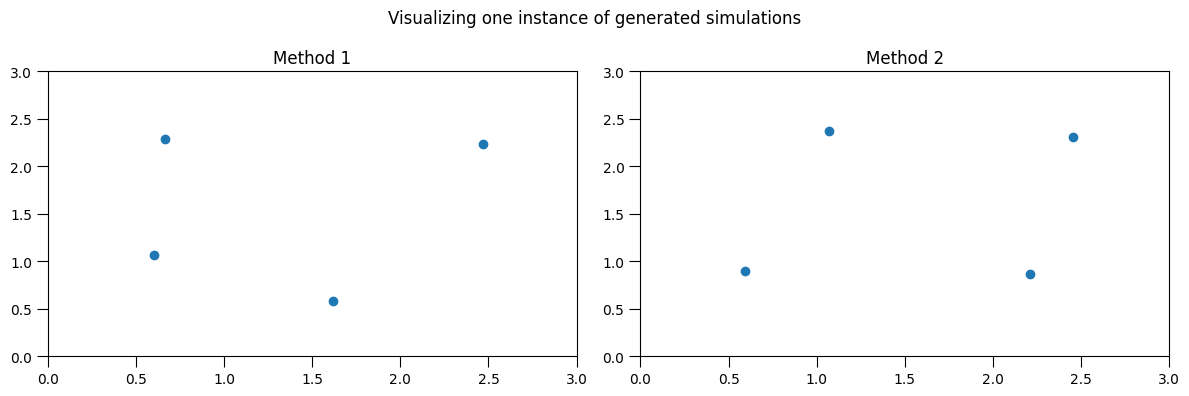

Exercise 9.2:


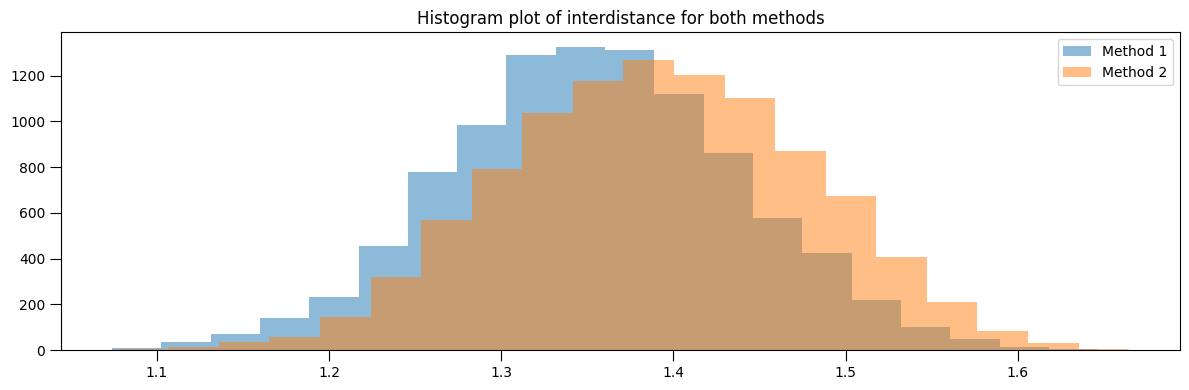

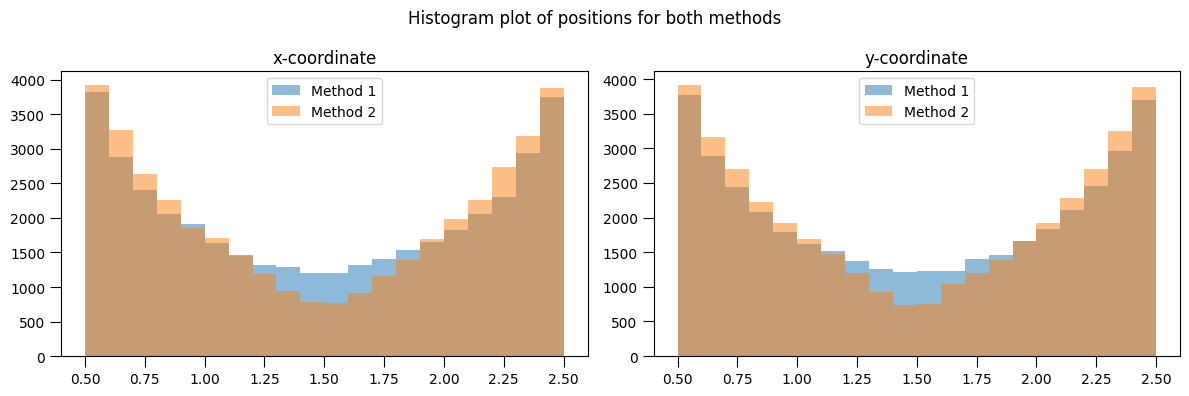

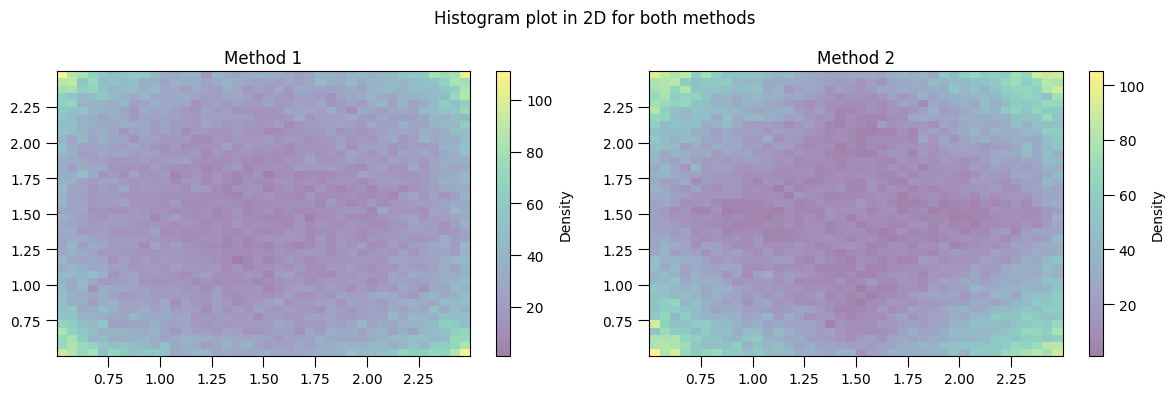

Exercise 9.3:


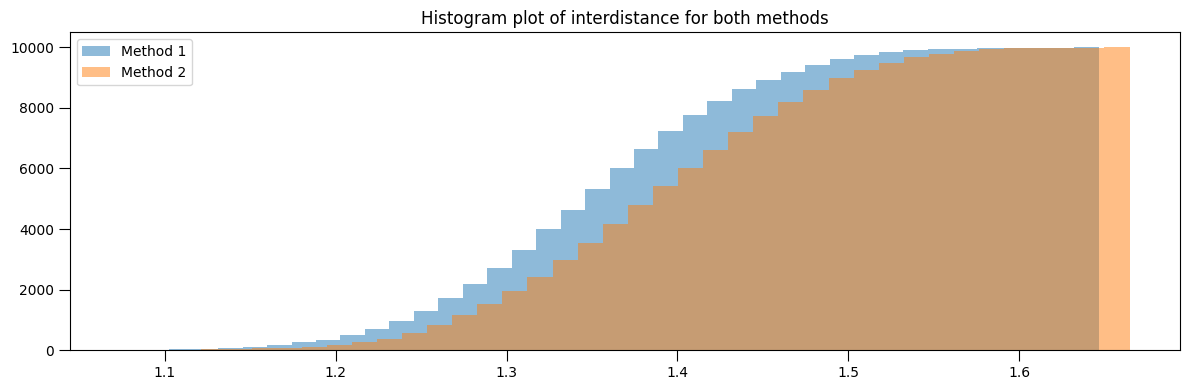

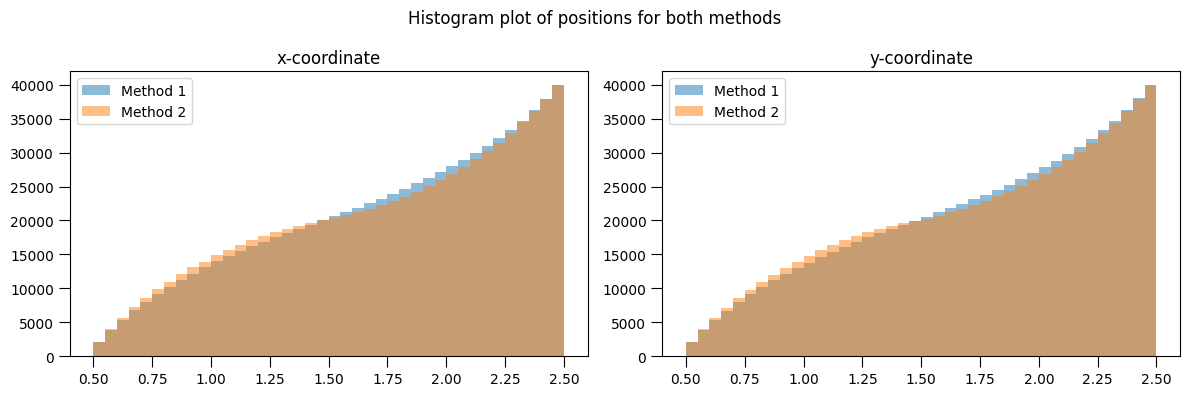

Extra plots:


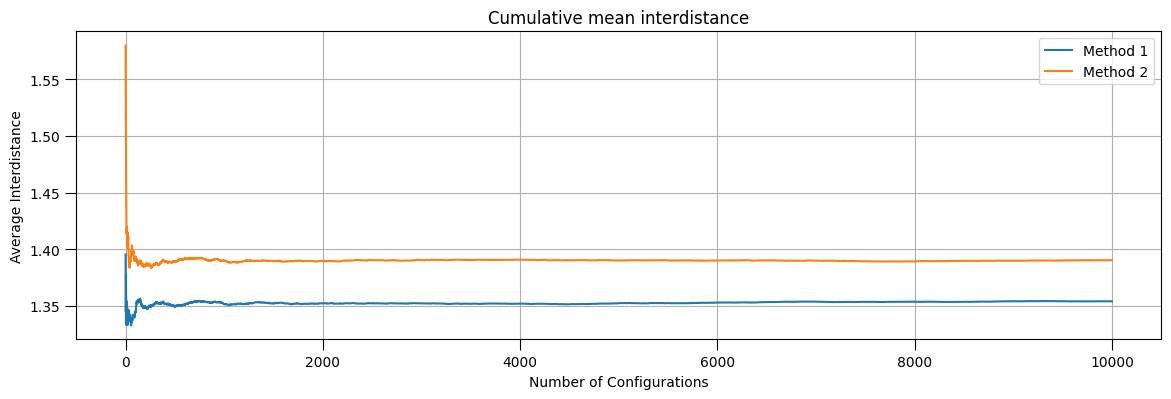

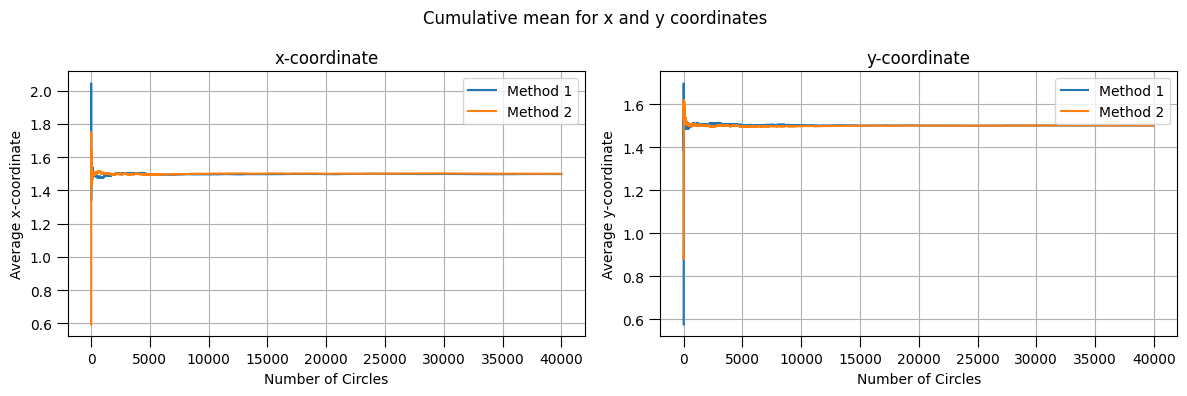

In [6]:
# Exercise 9

M = 10000
N = 4
d = 2

sigma = 1
L = 3

simulation = hardwall_hard_sphere(N,d,sigma,L)

## Exercise 1
print("Exercise 9.1:")
# Generating configurations
configurations1 = np.zeros((M,N,d))
interdistance1 = np.zeros(M)

configurations2 = np.zeros((M,N,d))
interdistance2 = np.zeros(M)

for i in range(M):
    # Generating positions
    configurations1[i,:,:] = np.array(simulation.rejection_sampling_1())
    configurations2[i,:,:] = np.array(simulation.rejection_sampling_2())
    # Getting interdistances

    for j in range(N):
        for k in range(j):
            interdistance1[i] += simulation.get_periodic_distance(configurations1[i,j,:], configurations1[i,k,:])
            interdistance2[i] += simulation.get_periodic_distance(configurations2[i,j,:], configurations2[i,k,:])

    interdistance1[i] /= N * (N-1) / 2
    interdistance2[i] /= N * (N-1) / 2
    
# Visualizing one simulation
plt.figure(figsize=(12,4))
plt.suptitle("Visualizing one instance of generated simulations")

plt.subplot(1,2,1)
plt.title("Method 1")
x = configurations1[0,:,0]
y = configurations1[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.subplot(1,2,2)
plt.title("Method 2")
x = configurations2[0,:,0]
y = configurations2[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.tight_layout()
plt.show()

## Exercise 2
print("Exercise 9.2:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Method 1', alpha = 0.5, bins = 20)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Method 1', bins = 20)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Method 1', bins = 20)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram 2D plot
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot in 2D for both methods")

plt.subplot(1,2,1)
plt.title("Method 1")
plt.hist2d(configurations1[:,:,0].flatten(), configurations1[:,:,1].flatten(), alpha = 0.5, bins = 40)
plt.colorbar().set_label('Density')

plt.subplot(1,2,2)
plt.title("Method 2")
plt.hist2d(configurations2[:,:,0].flatten(), configurations2[:,:,1].flatten(), alpha = 0.5, bins = 40)
plt.colorbar().set_label('Density')

plt.tight_layout()
plt.show()

## Exercise 3
print("Exercise 9.3:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Method 1', alpha = 0.5, bins = 40, cumulative=True)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 40, cumulative=True)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Method 1', bins = 40, cumulative = True)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 40, cumulative = True)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Method 1', bins = 40, cumulative = True)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 40, cumulative = True)
plt.legend()

plt.tight_layout()
plt.show()

# Extra plots
print("Extra plots:")

plt.figure(figsize=(14,4))
plt.title("Cumulative mean interdistance")
plt.plot(np.cumsum(interdistance1) / np.arange(1, M + 1), label='Method 1')
plt.plot(np.cumsum(interdistance2) / np.arange(1, M + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Configurations")
plt.ylabel("Average Interdistance")
plt.grid(True)
plt.show()

# Partial cumulative plot for x-coordinate and y-coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Cumulative mean for x and y coordinates")

plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.plot(np.cumsum(configurations1[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average x-coordinate")
plt.grid(True)

plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.plot(np.cumsum(configurations1[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average y-coordinate")
plt.grid(True)

plt.tight_layout()
plt.show()

> 10. Do you have agreement between the two methods? Is a method not correct?
> 11. Are both methods still correct in the periodic case though?
> 12. Comment the shape of the obtained stationary distribution of the x- and y-coordinates, for instance is it surprising it is not uniform anymore? (To go further: https://en.wikipedia.org/wiki/Depletion_force)
> 13. Redo the simulations for $L=16$, are the effects observed in $L=3$ also present here?

Answers:

**Exercise 10:**

We can see from the plots that the two methods **do not agree**:

- The main issue with method 1 is that it assumes that the first sphere can be sampled uniformly in the hard wall configuration. This is not true, and can be easily be visualized if we are in the case where $L$ is close to $\sigma$. In such configurations, a sphere first taken in the center will force a configuration that is less likely to occur. In order words, the position of the first sphere is not independant on the positions of the other ones.

- Method 2 is more robust since it works as if it selected all spheres "**at once**", not one by one. It therefore creates configurations that are indeed what we search in our Monte Carlo simulation.

- This is precisely what we observe in the **histogram plots**. Method 1 has more spheres at the center (histogram of x and y coordinates), while method 2 concentrates at the borders. Altough both methods converge, the method 2 is the one that correspond to the correct Monte Carlo simulation that we search. In terms of the interdistance, we should therefore use the plot of method 2 as the correct one.

It is interesting to remark that this time the interdistance of method 1 is smaller. This makes sense since when we take a sphere in the center it is more likely that the other spheres will be closer to each other, whereas in method 2 this is not the case.

**Exercise 11:**

In the periodic case, method 1 is less impacted compared to the hard wall one, however it is not exactly correct. As previously demonstrated in the cumulative mean of the interdistance plot (extra plot) in exercise 6 we can see the the two methods yield different configurations. This effect is, most likely, due to the fact that method 1 value more spaced configurations than close ones - further away spheres are more likely to be accepted. Method 2, since it generates all spheres at once, is the correct Monte Carlo sampling of the distribution that we search to approximate, altough slower.

**Exercise 12:**

As previously commented in Exercise 10, this is not surprising - a sphere in the center will block more surface area for new centers than at the border, making such configurations less likely to occur. Therefore, most of the time we will see circles that are more concentrated at the extremities of the square.

One might question that, since method 1 will still allow for the first circle to be generated at the center equally as likely to anywhere else, such effects should not occur. Altough this is true in the sense (we observe more instances of x and y coordinates at the center for method one), since such circles block an important area, the following ones will concentrate at the extremities.


Exercise 13.1:


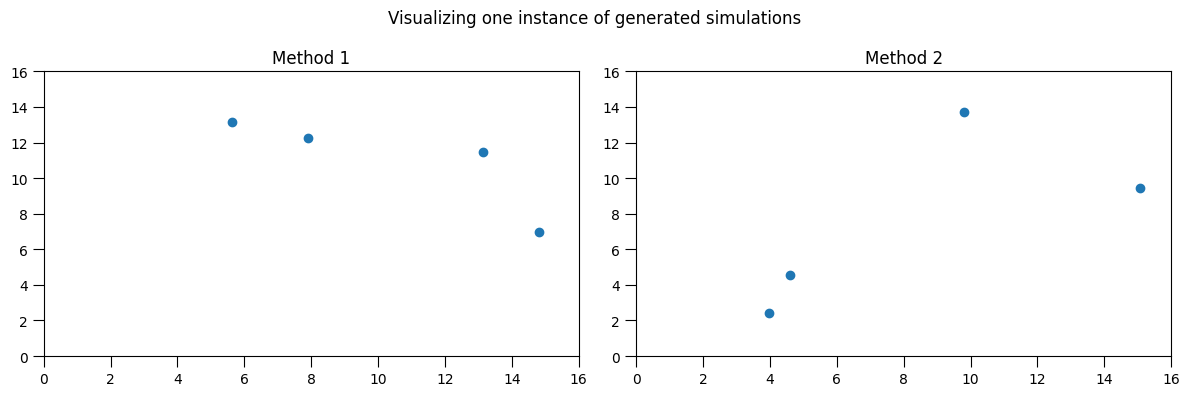

Exercise 13.2:


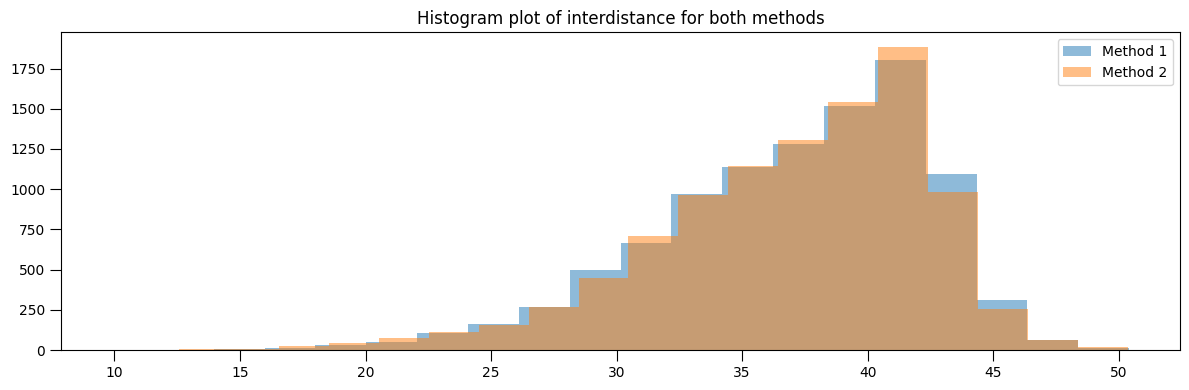

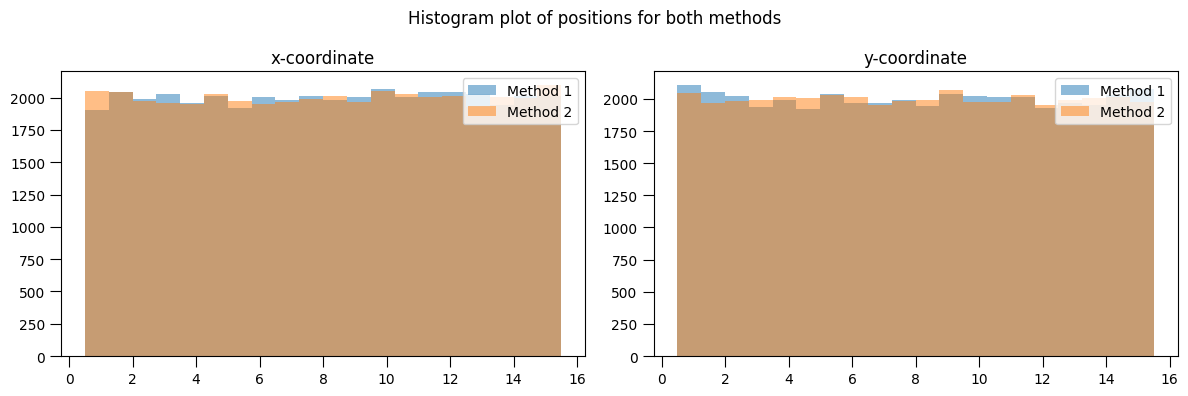

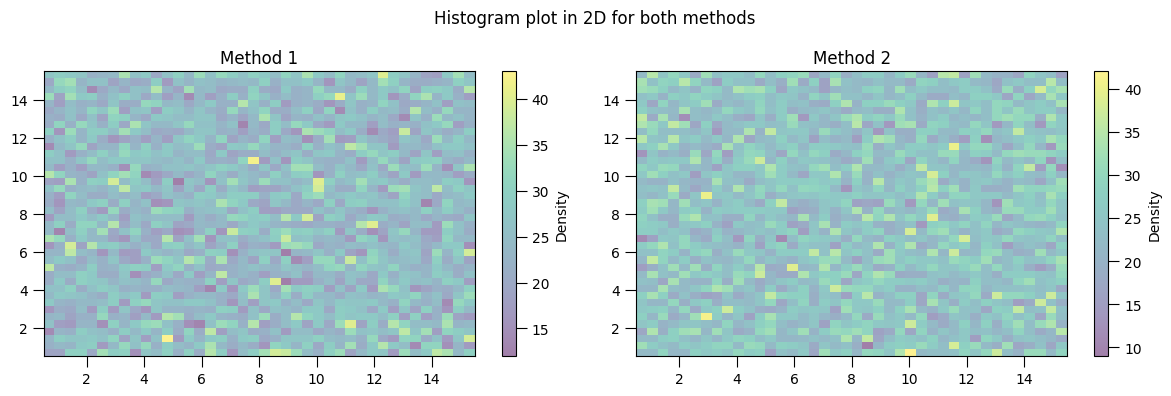

Exercise 13.3:


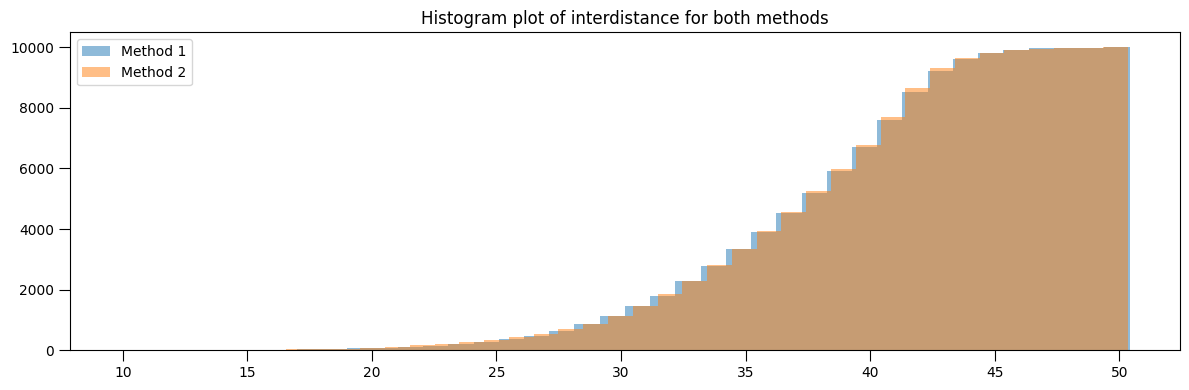

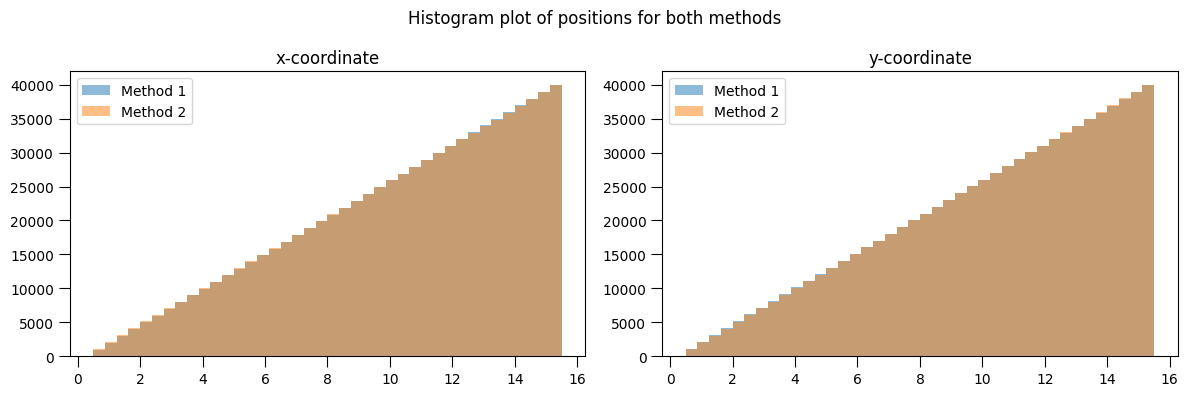

Extra plots:


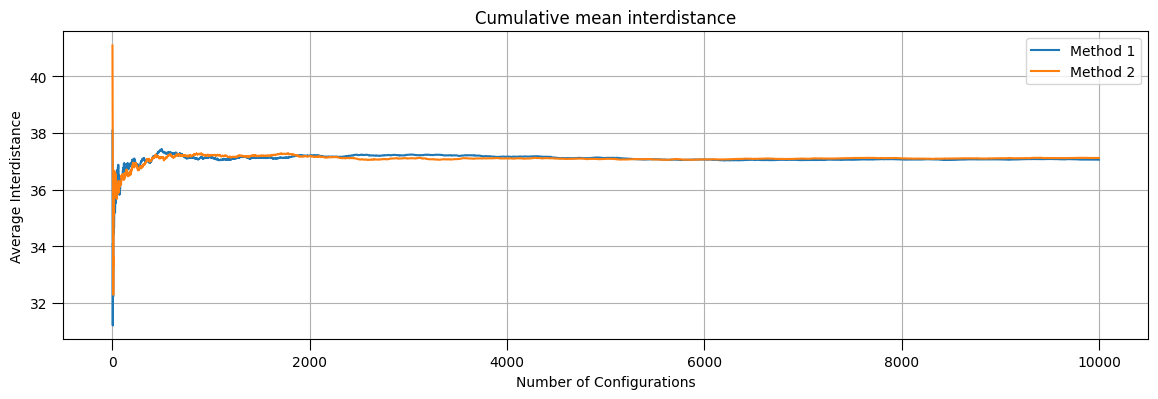

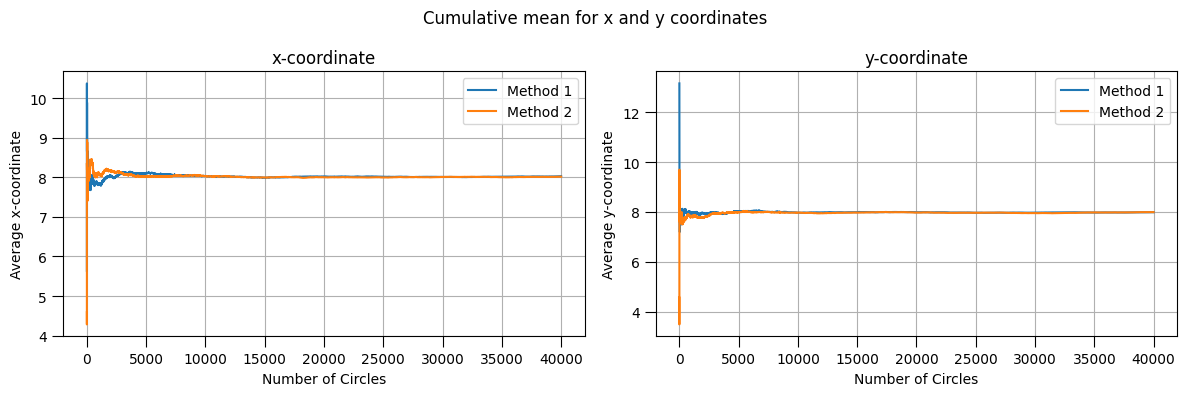

In [7]:
# Exercise 13

M = 10000
N = 4
d = 2

sigma = 1
L = 16

simulation = hardwall_hard_sphere(N,d,sigma,L)

## Exercise 1
print("Exercise 13.1:")
# Generating configurations
configurations1 = np.zeros((M,N,d))
interdistance1 = np.zeros(M)

configurations2 = np.zeros((M,N,d))
interdistance2 = np.zeros(M)

for i in range(M):
    # Generating positions
    configurations1[i,:,:] = np.array(simulation.rejection_sampling_1())
    configurations2[i,:,:] = np.array(simulation.rejection_sampling_2())
    # Getting interdistances

    for j in range(N):
        for k in range(j):
            interdistance1[i] += simulation.get_periodic_distance(configurations1[i,j,:], configurations1[i,k,:])
            interdistance2[i] += simulation.get_periodic_distance(configurations2[i,j,:], configurations2[i,k,:])

    # interdistance1[i] /= N * (N-1) / 2
    # interdistance2[i] /= N * (N-1) / 2
    
# Visualizing one simulation
plt.figure(figsize=(12,4))
plt.suptitle("Visualizing one instance of generated simulations")

plt.subplot(1,2,1)
plt.title("Method 1")
x = configurations1[0,:,0]
y = configurations1[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.subplot(1,2,2)
plt.title("Method 2")
x = configurations2[0,:,0]
y = configurations2[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.tight_layout()
plt.show()

## Exercise 2
print("Exercise 13.2:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Method 1', alpha = 0.5, bins = 20)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Method 1', bins = 20)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Method 1', bins = 20)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram 2D plot
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot in 2D for both methods")

plt.subplot(1,2,1)
plt.title("Method 1")
plt.hist2d(configurations1[:,:,0].flatten(), configurations1[:,:,1].flatten(), alpha = 0.5, bins = 40)
plt.colorbar().set_label('Density')

plt.subplot(1,2,2)
plt.title("Method 2")
plt.hist2d(configurations2[:,:,0].flatten(), configurations2[:,:,1].flatten(), alpha = 0.5, bins = 40)
plt.colorbar().set_label('Density')

plt.tight_layout()
plt.show()

## Exercise 3
print("Exercise 13.3:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Method 1', alpha = 0.5, bins = 40, cumulative=True)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 40, cumulative=True)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Method 1', bins = 40, cumulative = True)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 40, cumulative = True)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Method 1', bins = 40, cumulative = True)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 40, cumulative = True)
plt.legend()

plt.tight_layout()
plt.show()

# Extra plots
print("Extra plots:")

plt.figure(figsize=(14,4))
plt.title("Cumulative mean interdistance")
plt.plot(np.cumsum(interdistance1) / np.arange(1, M + 1), label='Method 1')
plt.plot(np.cumsum(interdistance2) / np.arange(1, M + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Configurations")
plt.ylabel("Average Interdistance")
plt.grid(True)
plt.show()

# Partial cumulative plot for x-coordinate and y-coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Cumulative mean for x and y coordinates")

plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.plot(np.cumsum(configurations1[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average x-coordinate")
plt.grid(True)

plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.plot(np.cumsum(configurations1[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average y-coordinate")
plt.grid(True)

plt.tight_layout()
plt.show()

Comments on plots of **Exercise 13**: 

- We remark that the border effects that happened when $L=3$ are no longer present when $L=16$: x-coordinate and y-coordinate are rather uniform, and interdistance is fairly **similar** to the one of the previous exercises when borders are periodic (of course not the same since circles cannot occupy for example $x\in[0,\frac{\sigma}{2})$). When $L=3$, a circle in the center created an important invalid zone for new circles: such configurations were therefore less likely. Now, when $L=16$, such effects mostly disapear since there is enough space for all circles to even be generated iteratively such as in method one without having to reject samples.
- We also remark that results from both methods 1 and 2 are fairly similar, which was not the case before. This makes sense, since when colisions are not that often, method 1 will create all circles of a given configuration without having to reject often, doing almost the same thing as method 2.

## 3) Markov-Chain Monte Carlo

We now consider a sampling based on a Markov chain for the hard-wall case which is defined as follows for $\delta >0$.
Given the current point $X^k= (X_i^k)_{i=1}^N \in \mathbb{R}^{d\times N}$:
- a) Sample from $i^{k+1} \in \{1,\ldots,N\}$ uniformly 
- b) Propose $Y^{k+1}_{i^{k+1}} = X^k_{i^{k+1}} + \delta Z^{k+1}$ where $Z^{k+1} \sim \mathrm{N}(0,\delta^2 \mathrm{Id})$ is independent from the past, and $Y^{k+1}_i = X^{k+1}_i$ for $i \neq i^{k+1}$.
- c) Set $X^{k+1}$ from $X^k$ and $Y^{k+1}$ using the Metropolis-Hastings accept-reject step seen in course.

> 14. Complete the class ```hardwall_hard_sphere``` to include a routine producing samples obtained by a Markov-chain Monte Carlo method. For instance, consider a Metropolis-like scheme with a Markov kernel proposing to move a single random sphere by a small Gaussian increment ($\mathcal{N}(0,\delta^2)$) each time.
> 15. For $N=4, L=3$, generate 10000 samples by the Markov-chain and rejection sampling scheme of your choice. Output also the averaged acceptance rates of the reject sampling and Markov-chain sampling scheme. Compare the obtained histograms of the interdistance between spheres and of the x- and y-coordinates of spheres.
> 16. What can you say about the apparent speed of convergence of both methods? Take into account the acceptance rates and the number of moved spheres between successive configurations in your analysis.
> 17. For $N=4, L =2.5$, redo the simulations (you can choose to generate only 1000 configurations). What can you say about the acceptance rates of both methods? How did you choose the $\delta$ value?
> 18. Comment the stationary distribution for a sphere position.

Comment **Exercise 14**:

TODO

In [8]:
# Exercise 14

class hardwall_hard_sphere:
    def __init__(self,N=4, d=2, sigma=1.0, L = 16):
        # Parameter initialization
        self.N = N #number of spheres
        self.d = d #dimension of box
        self.sigma = sigma #sphere diameter
        self.L = L #length of square box
    
    def get_periodic_distance(self, x_1,x_2):        
        delta_x = x_1-x_2
        diff_x_periodic = min(abs(delta_x[0]),self.L-abs(delta_x[0]))
        diff_y_periodic = min(abs(delta_x[1]),self.L-abs(delta_x[1]))
        d_sq = diff_x_periodic ** 2.0 + diff_y_periodic ** 2.0
        return d_sq**0.5
    
    def pair_overlap_check(self,x_1, x_2):
        d = self.get_periodic_distance(x_1,x_2)
        if d < self.sigma:
            return True  #There is an overlap          
        return False
    
    def generate_sphere_position(self):
        # Generate directly the circle uniformly on the allowed region
        x_i_new = np.random.uniform(self.sigma/2, self.L - self.sigma/2, size=2)
        return x_i_new
    
    def rejection_sampling_metropolis(self, M, delta):
        configurations = np.zeros((M, self.N, self.d))
        
        acceptance = 0
        rejection = 0
        
        # Generate first instance
        configurations[0,:,:], _ = self.rejection_sampling_2()
        
        for i in range(1,M):
            # Generating positions
            configurations[i,:,:] = configurations[i-1,:,:]
            
            i_k1 = np.random.randint(0, self.N)
            new_sphere = configurations[i,i_k1,:] + np.random.normal(0, delta, self.d)
            
            valid = True
            for id_sphere in range(N):
                if id_sphere == i_k1:
                    for coordinate in range(self.d):
                        if new_sphere[coordinate] < self.sigma/2 or new_sphere[coordinate] > self.L - self.sigma/2:
                            valid = False
                            break
                else:
                    valid = valid and not self.pair_overlap_check(new_sphere, configurations[i,id_sphere,:])
                    if not valid: break
                    
            if valid:
                acceptance += 1
                configurations[i,i_k1,:] = new_sphere
            else:
                rejection += 1    
            
        acceptance /= M - 1
        rejection /= M - 1
        
        return configurations, acceptance, rejection
        
    def rejection_sampling_1(self):
        x = []
        while len(x) < self.N:
            overlapping_proposition = True
            while overlapping_proposition:
                x_i_new = self.generate_sphere_position()
                overlapping_proposition = False
                for x_j in x:
                    if self.pair_overlap_check(x_j,x_i_new):
                        overlapping_proposition = True
                        break
            x += [x_i_new]
        return x
    
       
    def rejection_sampling_2(self):                    
        x = []
        
        rejection = 0
        
        while  len(x) < self.N:
            while len(x) < self.N:
                x_i_new = self.generate_sphere_position()
                overlapping_proposition = False
                for x_j in x:
                    if self.pair_overlap_check(x_j,x_i_new):
                        overlapping_proposition = True
                        break
                if overlapping_proposition:
                    rejection += 1
                    x = []
                    break
                x += [x_i_new]
                
        return x, rejection 

Exercise 15.1:


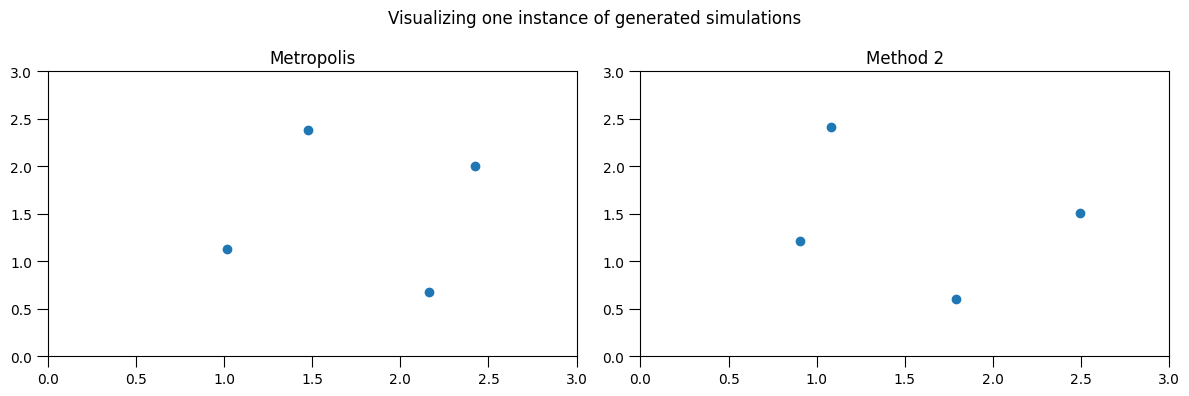

Exercise 15.2:


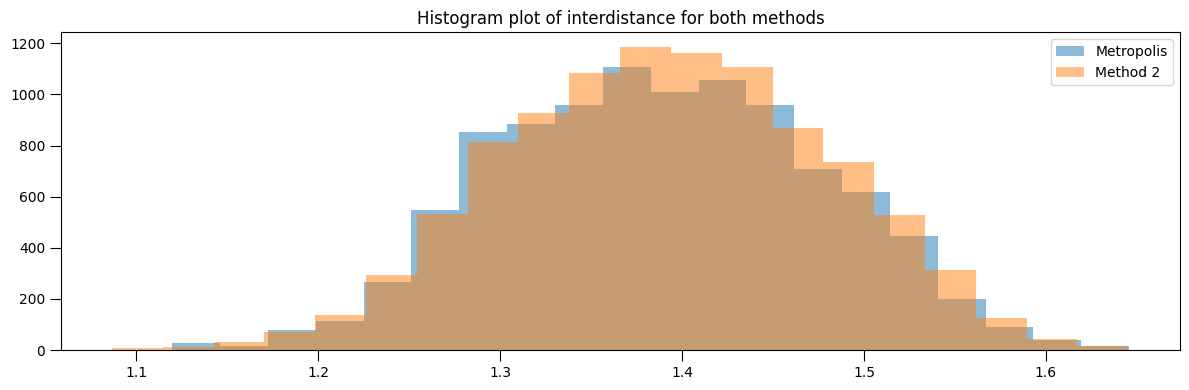

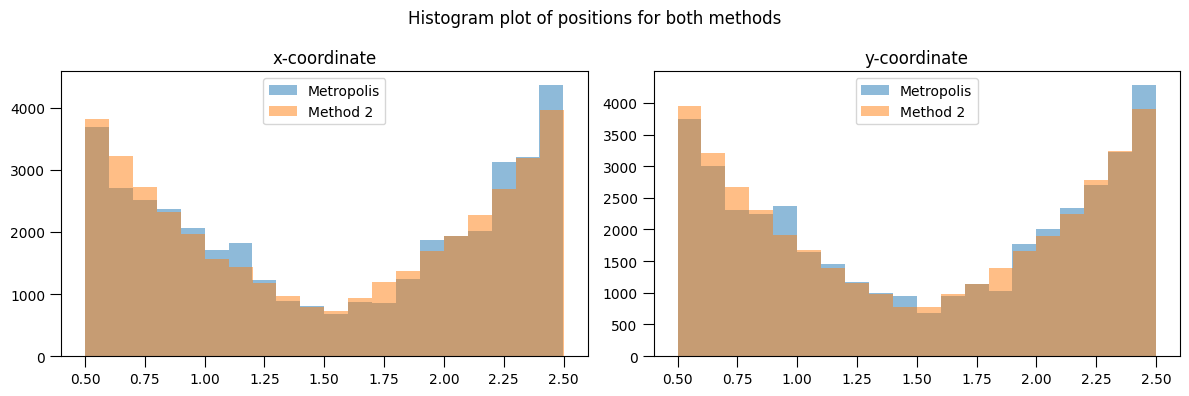

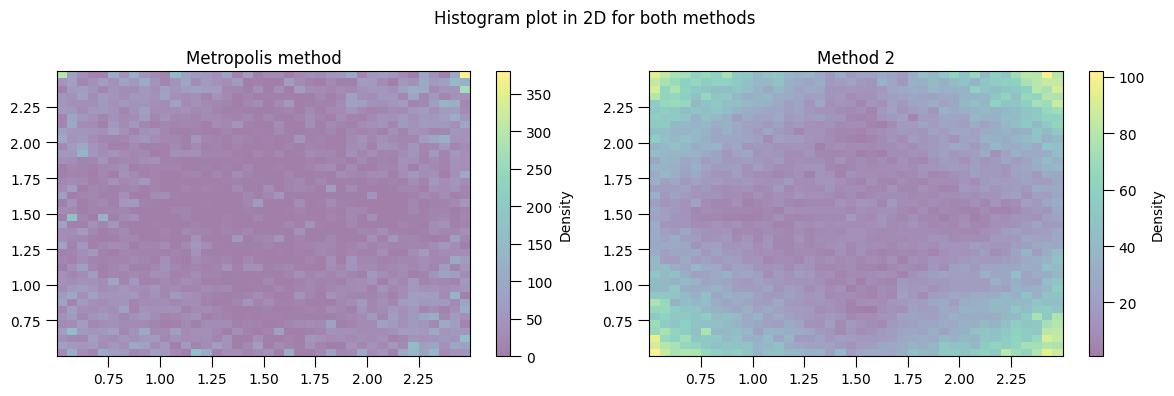

Exercise 15.3:


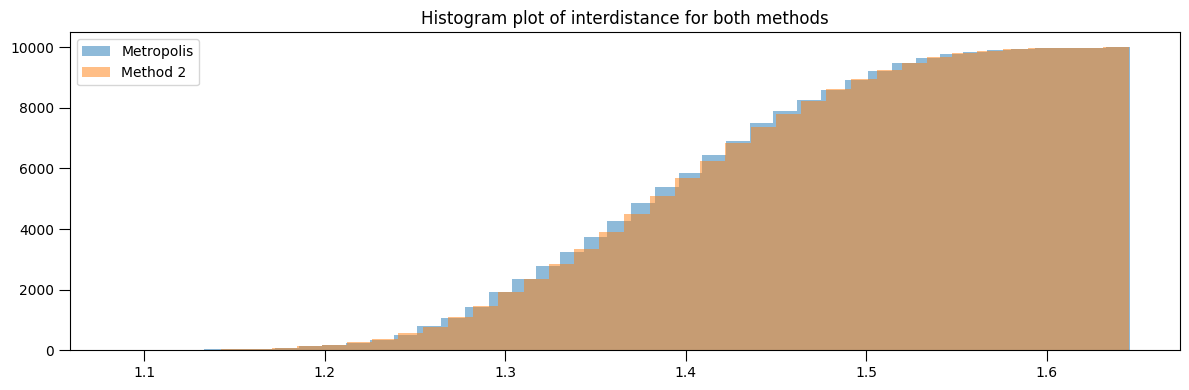

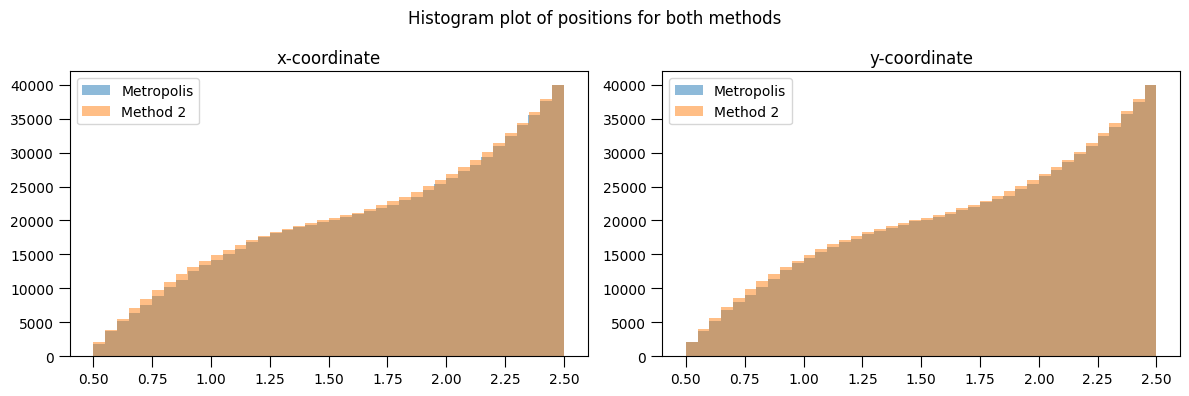

Extra plots:


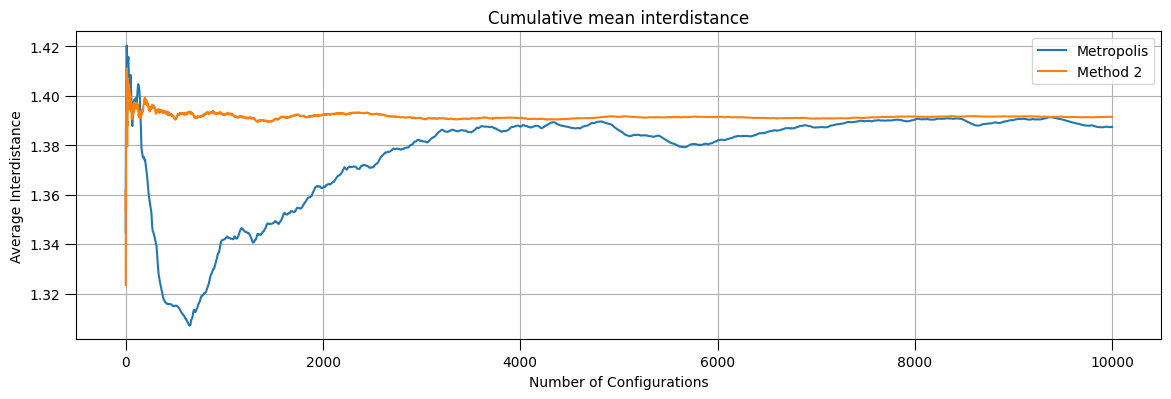

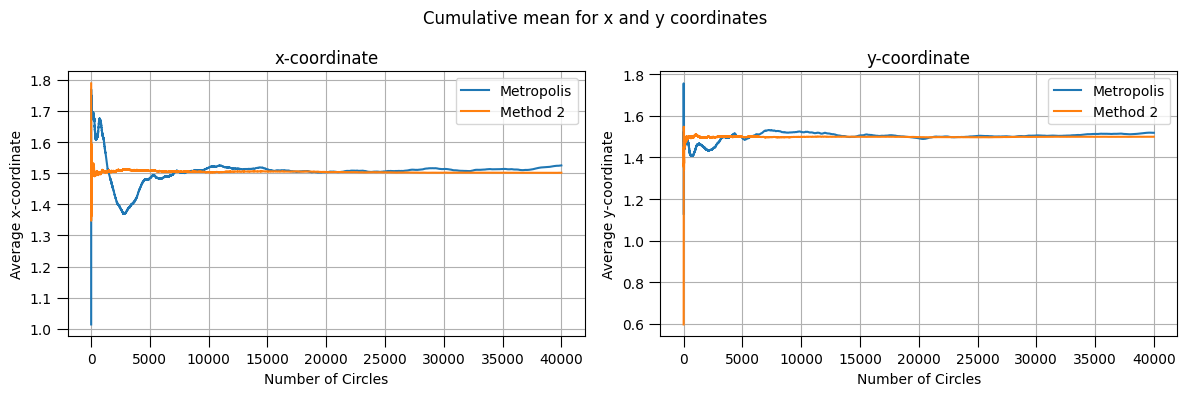

##### Acceptance and Rejection rates #####
Rejection sampling method 2
	 Acceptance: 0.010218679746576753
	 Rejection: 0.9897813202534232
Rejection sampling method 2
	 Acceptance Metropolis: 0.502050205020502
	 Rejection Metropolis: 0.49794979497949793


In [9]:
# Exercise 15

M = 10000
N = 4
d = 2

sigma = 1
L = 3
delta = 0.2

simulation = hardwall_hard_sphere(N,d,sigma,L)

## Exercise 1
print("Exercise 15.1:")
# Generating configurations
configurations1 = np.zeros((M,N,d))
interdistance1 = np.zeros(M)

configurations2 = np.zeros((M,N,d))
interdistance2 = np.zeros(M)

configurations1, acceptance_metropolis, rejection_metropolis = simulation.rejection_sampling_metropolis(M, delta)
rejection_method2 = 0

for i in range(M):
    # Generating positions
    x, rejection = simulation.rejection_sampling_2()
    configurations2[i,:,:] = np.array(x)
    rejection_method2 += rejection
    # Getting interdistances

    for j in range(N):
        for k in range(j):
            interdistance1[i] += simulation.get_periodic_distance(configurations1[i,j,:], configurations1[i,k,:])
            interdistance2[i] += simulation.get_periodic_distance(configurations2[i,j,:], configurations2[i,k,:])

    interdistance1[i] /= N * (N-1) / 2
    interdistance2[i] /= N * (N-1) / 2
    
rejection_method2 /= (rejection_method2 + M)
acceptance_method2 = 1 - rejection_method2
    
# Visualizing one simulation
plt.figure(figsize=(12,4))
plt.suptitle("Visualizing one instance of generated simulations")

plt.subplot(1,2,1)
plt.title("Metropolis")
x = configurations1[0,:,0]
y = configurations1[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.subplot(1,2,2)
plt.title("Method 2")
x = configurations2[0,:,0]
y = configurations2[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.tight_layout()
plt.show()

## Exercise 2
print("Exercise 15.2:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Metropolis', alpha = 0.5, bins = 20)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Metropolis', bins = 20)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Metropolis', bins = 20)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram 2D plot
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot in 2D for both methods")

plt.subplot(1,2,1)
plt.title("Metropolis method")
plt.hist2d(configurations1[:,:,0].flatten(), configurations1[:,:,1].flatten(), alpha = 0.5, bins = 40)
plt.colorbar().set_label('Density')

plt.subplot(1,2,2)
plt.title("Method 2")
plt.hist2d(configurations2[:,:,0].flatten(), configurations2[:,:,1].flatten(), alpha = 0.5, bins = 40)
plt.colorbar().set_label('Density')

plt.tight_layout()
plt.show()

## Exercise 3
print("Exercise 15.3:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Metropolis', alpha = 0.5, bins = 40, cumulative=True)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 40, cumulative=True)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Metropolis', bins = 40, cumulative = True)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 40, cumulative = True)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Metropolis', bins = 40, cumulative = True)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 40, cumulative = True)
plt.legend()

plt.tight_layout()
plt.show()

# Extra plots
print("Extra plots:")

plt.figure(figsize=(14,4))
plt.title("Cumulative mean interdistance")
plt.plot(np.cumsum(interdistance1) / np.arange(1, M + 1), label='Metropolis')
plt.plot(np.cumsum(interdistance2) / np.arange(1, M + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Configurations")
plt.ylabel("Average Interdistance")
plt.grid(True)
plt.show()

# Partial cumulative plot for x-coordinate and y-coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Cumulative mean for x and y coordinates")

plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.plot(np.cumsum(configurations1[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Metropolis')
plt.plot(np.cumsum(configurations2[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average x-coordinate")
plt.grid(True)

plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.plot(np.cumsum(configurations1[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Metropolis')
plt.plot(np.cumsum(configurations2[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average y-coordinate")
plt.grid(True)

plt.tight_layout()
plt.show()

print("##### Acceptance and Rejection rates #####")
print("Rejection sampling method 2")
print(f"\t Acceptance: {acceptance_method2}")
print(f"\t Rejection: {rejection_method2}")
print("Rejection sampling method 2")
print(f"\t Acceptance Metropolis: {acceptance_metropolis}")
print(f"\t Rejection Metropolis: {rejection_metropolis}")

Answers:

**Exercise 15**:

We can see that both methods seem to agree, with the Metropolis algorithm having a slower convergence rate than our second rejection method. This, however, comes at the hidden cost of the second method of high rejection rate. As we can see the rejection for method 2 was around $99\%$, whereas the one of Metropolis was $50\%$. Despite the fact that the Metropolis plot is more irregular which makes plots different, it is very clear that both methods are converging to the same solution, something that can be very well observed trough the extra plot of the cumulative mean interdistance. Hence, the histogram plot of interdistance, x-coordiante, and y-coordinate are very similar. In particular, the one of the cumulative plots shows that both methods follow roughly the same distribution. 

**Exercise 16**:

As discussed in Exercise 15, Metropolis algorithm seems to have a slower rate of convergence compared to the second rejection method, however, this comes at the hidden cost of the second method of a high rejection rate ($99\%$ for method 2 compared to only $50\%$ for Metropolis). Hence, altough method 2 seems to converge faster, as only $1\%$ of configurations are accepted, it is like we generated 100 times more configurations compared to the Metropolis. If we ran Metropolis for 100 times more iterations we should expect similar results to method 2 if they have the same rate of convergence. This is indeed what is observed in the plots below, and we remark that the time to generate way more instances of Metropolis does not cost significantly in time.

It is important to remark that altough a rejection from the rejection sampling means more iterations to be performed in order to generate a configuration, a rejection in the Metropolis algorithm is part of the algorithm itself. In a sense, a position of high probability density will reject more often, having more instances around such configurations, which is the intuition behind this algorithm. 

Exercise 16.1:


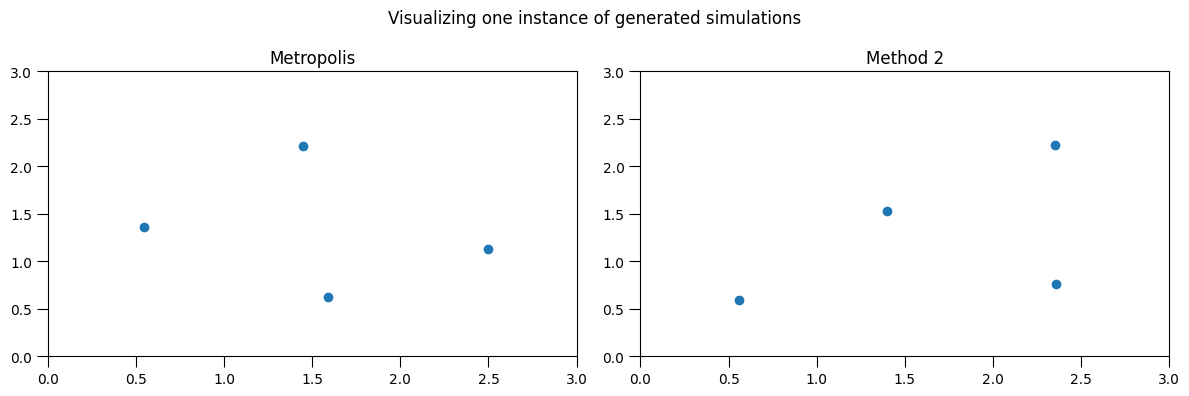

Exercise 16.2:


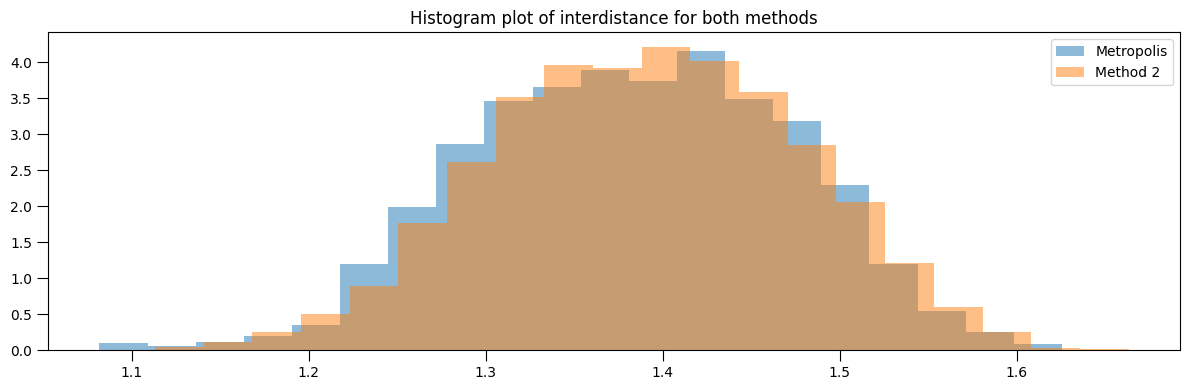

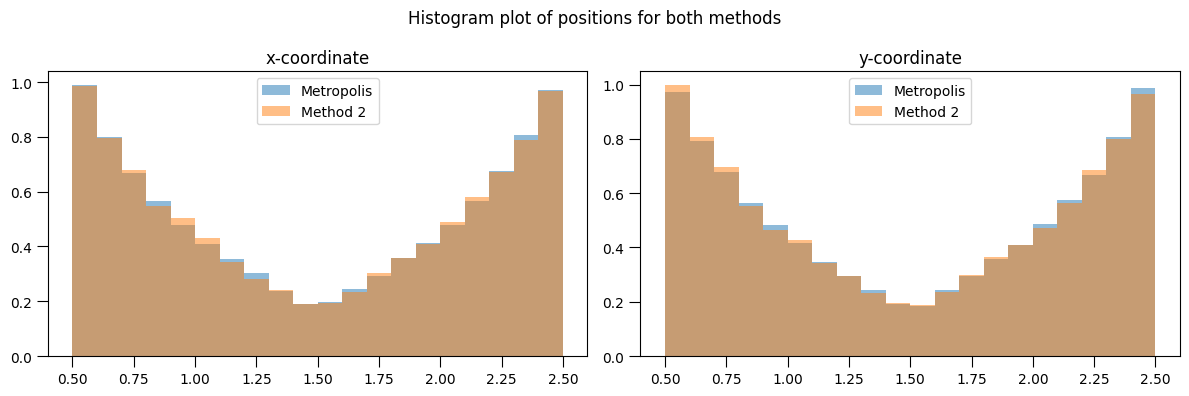

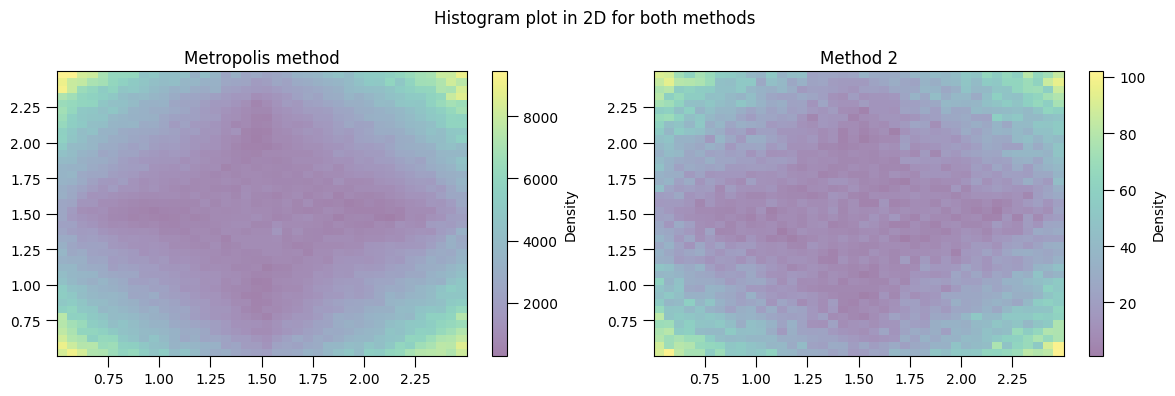

Exercise 16.3:


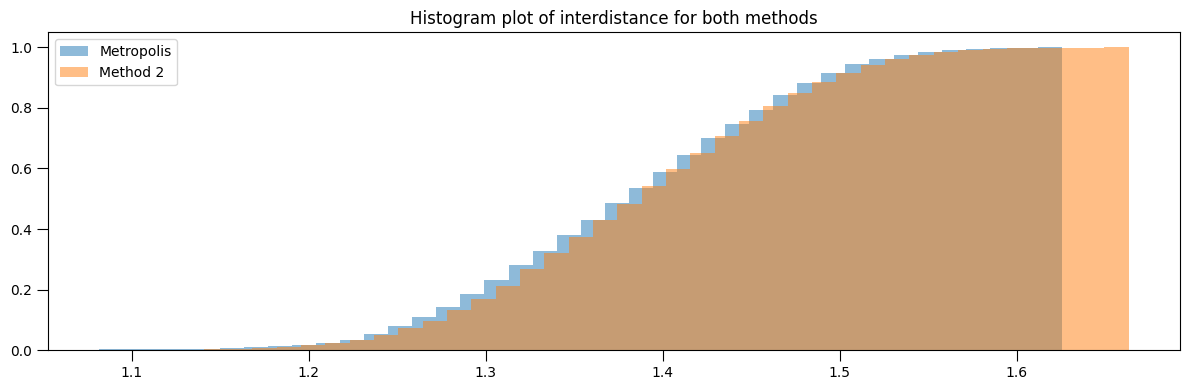

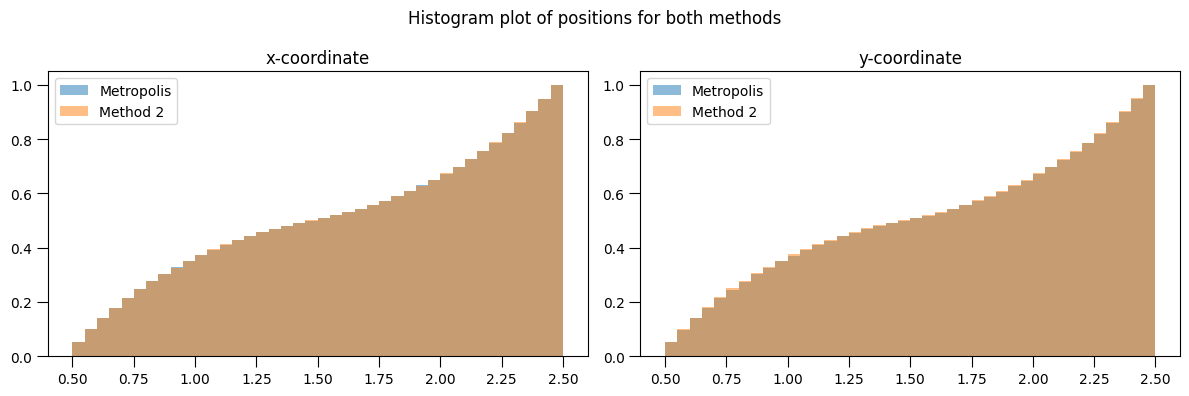

##### Acceptance and Rejection rates #####
Rejection sampling method 2
	 Acceptance: 0.010216549993665724
	 Rejection: 0.9897834500063343
Rejection sampling method 2
	 Acceptance Metropolis: 0.5050305050305051
	 Rejection Metropolis: 0.494969494969495


In [12]:
# Exercise 16 - taking into account the rejection.

M = 10000
N = 4
d = 2

sigma = 1
L = 3
delta = 0.2

simulation = hardwall_hard_sphere(N,d,sigma,L)

## Exercise 1
print("Exercise 16.1:")
# Generating configurations
configurations1 = np.zeros((M,N,d))
interdistance1 = np.zeros(M)

configurations2 = np.zeros((M,N,d))
interdistance2 = np.zeros(M)

configurations1, acceptance_metropolis, rejection_metropolis = simulation.rejection_sampling_metropolis(M * 100, delta)
rejection_method2 = 0

for i in range(M):
    # Generating positions
    x, rejection = simulation.rejection_sampling_2()
    configurations2[i,:,:] = np.array(x)
    rejection_method2 += rejection
    # Getting interdistances

    for j in range(N):
        for k in range(j):
            interdistance1[i] += simulation.get_periodic_distance(configurations1[i,j,:], configurations1[i,k,:])
            interdistance2[i] += simulation.get_periodic_distance(configurations2[i,j,:], configurations2[i,k,:])

    interdistance1[i] /= N * (N-1) / 2
    interdistance2[i] /= N * (N-1) / 2
    
rejection_method2 /= (rejection_method2 + M)
acceptance_method2 = 1 - rejection_method2
    
# Visualizing one simulation
plt.figure(figsize=(12,4))
plt.suptitle("Visualizing one instance of generated simulations")

plt.subplot(1,2,1)
plt.title("Metropolis")
x = configurations1[0,:,0]
y = configurations1[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.subplot(1,2,2)
plt.title("Method 2")
x = configurations2[0,:,0]
y = configurations2[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.tight_layout()
plt.show()

## Exercise 2
print("Exercise 16.2:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Metropolis', alpha = 0.5, bins = 20, density=True)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 20, density=True)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Metropolis', bins = 20, density=True)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 20, density=True)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Metropolis', bins = 20, density=True)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 20, density=True)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram 2D plot
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot in 2D for both methods")

plt.subplot(1,2,1)
plt.title("Metropolis method")
plt.hist2d(configurations1[:,:,0].flatten(), configurations1[:,:,1].flatten(), alpha = 0.5, bins = 40)
plt.colorbar().set_label('Density')

plt.subplot(1,2,2)
plt.title("Method 2")
plt.hist2d(configurations2[:,:,0].flatten(), configurations2[:,:,1].flatten(), alpha = 0.5, bins = 40)
plt.colorbar().set_label('Density')

plt.tight_layout()
plt.show()

## Exercise 3
print("Exercise 16.3:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Metropolis', alpha = 0.5, bins = 40, cumulative=True, density=True)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 40, cumulative=True, density=True)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Metropolis', bins = 40, cumulative = True, density=True)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 40, cumulative = True, density=True)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Metropolis', bins = 40, cumulative = True, density=True)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 40, cumulative = True, density=True)
plt.legend()

plt.tight_layout()
plt.show()

print("##### Acceptance and Rejection rates #####")
print("Rejection sampling method 2")
print(f"\t Acceptance: {acceptance_method2}")
print(f"\t Rejection: {rejection_method2}")
print("Rejection sampling method 2")
print(f"\t Acceptance Metropolis: {acceptance_metropolis}")
print(f"\t Rejection Metropolis: {rejection_metropolis}")

Exercise 17.1:


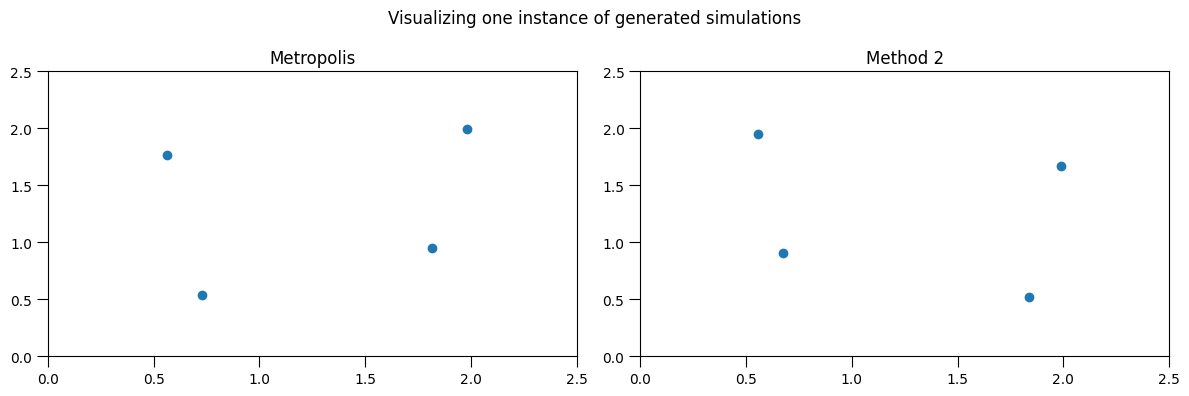

Exercise 17.2:


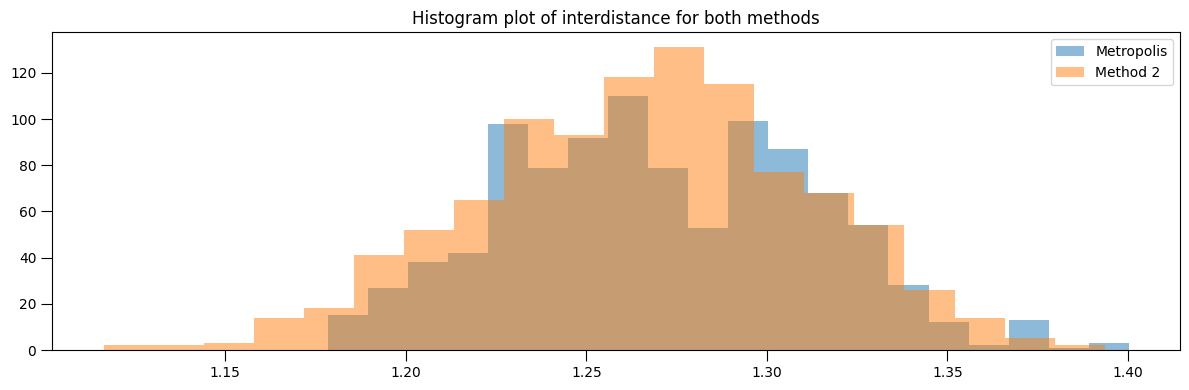

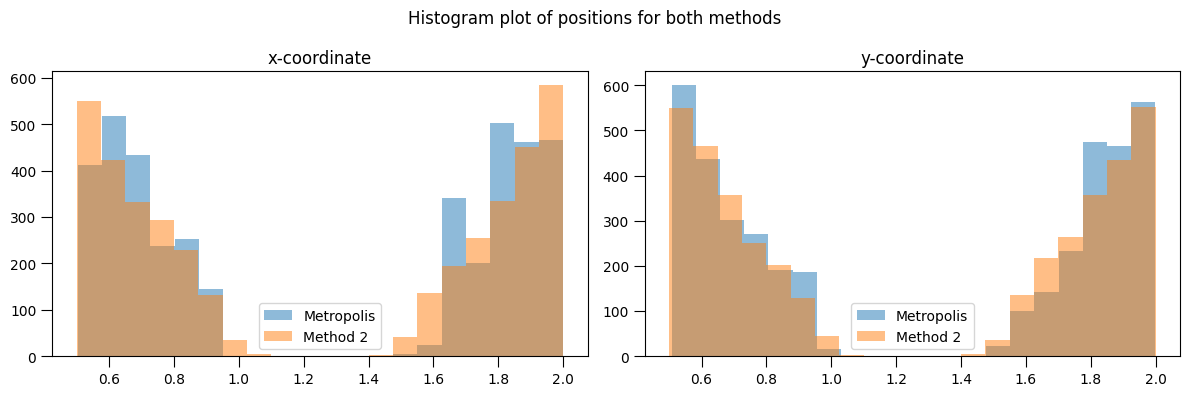

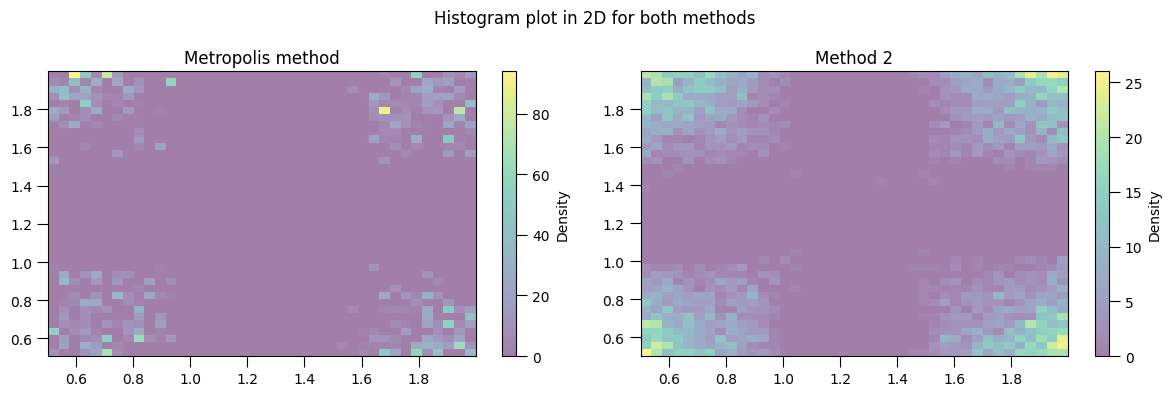

Exercise 17.3:


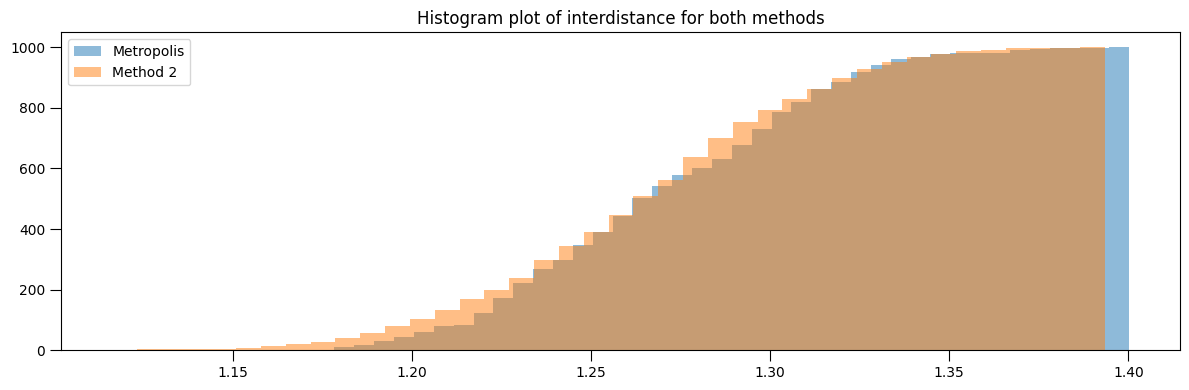

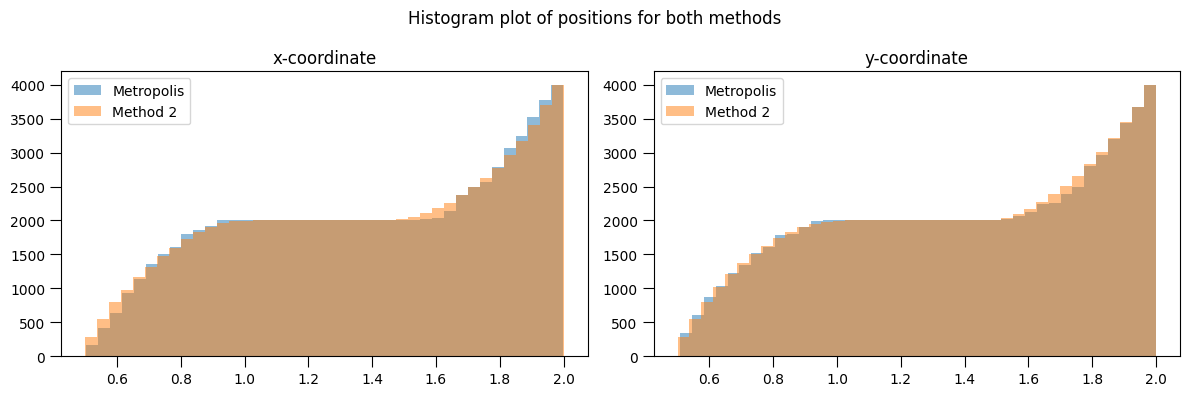

Extra plots:


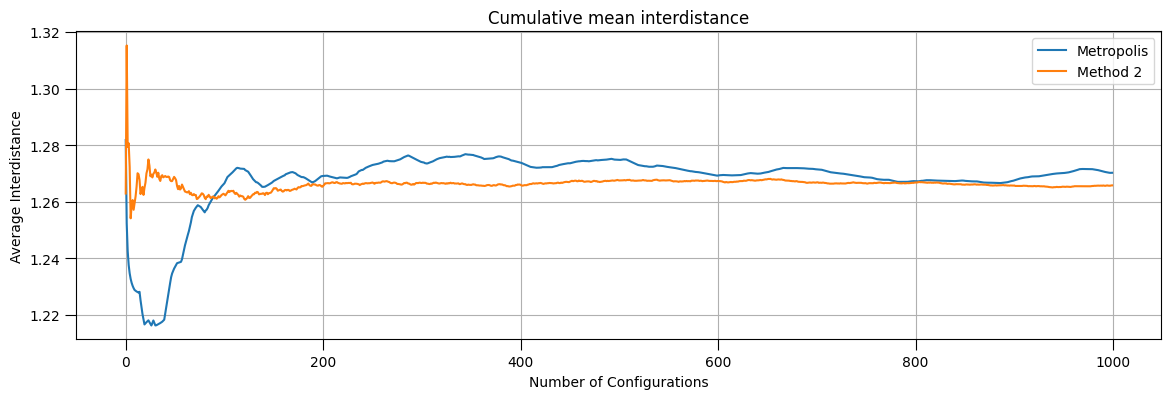

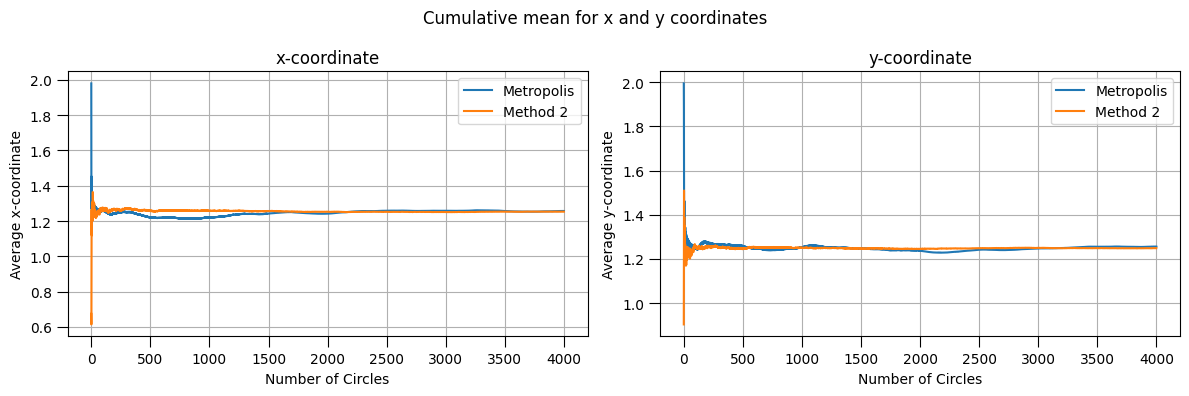

##### Acceptance and Rejection rates #####
Rejection sampling method 2
	 Acceptance: 0.00029597550269955253
	 Rejection: 0.9997040244973004
Rejection sampling method 2
	 Acceptance Metropolis: 0.3953953953953954
	 Rejection Metropolis: 0.6046046046046046


In [13]:
# Exercise 17

M = 1000
N = 4
d = 2

sigma = 1
L = 2.5
delta = 0.15

simulation = hardwall_hard_sphere(N,d,sigma,L)

## Exercise 1
print("Exercise 17.1:")
# Generating configurations
configurations1 = np.zeros((M,N,d))
interdistance1 = np.zeros(M)

configurations2 = np.zeros((M,N,d))
interdistance2 = np.zeros(M)

configurations1, acceptance_metropolis, rejection_metropolis = simulation.rejection_sampling_metropolis(M, delta)
rejection_method2 = 0

for i in range(M):
    # Generating positions
    x, rejection = simulation.rejection_sampling_2()
    configurations2[i,:,:] = np.array(x)
    rejection_method2 += rejection
    # Getting interdistances

    for j in range(N):
        for k in range(j):
            interdistance1[i] += simulation.get_periodic_distance(configurations1[i,j,:], configurations1[i,k,:])
            interdistance2[i] += simulation.get_periodic_distance(configurations2[i,j,:], configurations2[i,k,:])

    interdistance1[i] /= N * (N-1) / 2
    interdistance2[i] /= N * (N-1) / 2
    
rejection_method2 /= (rejection_method2 + M)
acceptance_method2 = 1 - rejection_method2
    
# Visualizing one simulation
plt.figure(figsize=(12,4))
plt.suptitle("Visualizing one instance of generated simulations")

plt.subplot(1,2,1)
plt.title("Metropolis")
x = configurations1[0,:,0]
y = configurations1[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.subplot(1,2,2)
plt.title("Method 2")
x = configurations2[0,:,0]
y = configurations2[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.tight_layout()
plt.show()

## Exercise 2
print("Exercise 17.2:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Metropolis', alpha = 0.5, bins = 20)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Metropolis', bins = 20)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Metropolis', bins = 20)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram 2D plot
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot in 2D for both methods")

plt.subplot(1,2,1)
plt.title("Metropolis method")
plt.hist2d(configurations1[:,:,0].flatten(), configurations1[:,:,1].flatten(), alpha = 0.5, bins = 40)
plt.colorbar().set_label('Density')

plt.subplot(1,2,2)
plt.title("Method 2")
plt.hist2d(configurations2[:,:,0].flatten(), configurations2[:,:,1].flatten(), alpha = 0.5, bins = 40)
plt.colorbar().set_label('Density')

plt.tight_layout()
plt.show()

## Exercise 3
print("Exercise 17.3:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Metropolis', alpha = 0.5, bins = 40, cumulative=True)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 40, cumulative=True)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Metropolis', bins = 40, cumulative = True)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 40, cumulative = True)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Metropolis', bins = 40, cumulative = True)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 40, cumulative = True)
plt.legend()

plt.tight_layout()
plt.show()

# Extra plots
print("Extra plots:")

plt.figure(figsize=(14,4))
plt.title("Cumulative mean interdistance")
plt.plot(np.cumsum(interdistance1) / np.arange(1, M + 1), label='Metropolis')
plt.plot(np.cumsum(interdistance2) / np.arange(1, M + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Configurations")
plt.ylabel("Average Interdistance")
plt.grid(True)
plt.show()

# Partial cumulative plot for x-coordinate and y-coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Cumulative mean for x and y coordinates")

plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.plot(np.cumsum(configurations1[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Metropolis')
plt.plot(np.cumsum(configurations2[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average x-coordinate")
plt.grid(True)

plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.plot(np.cumsum(configurations1[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Metropolis')
plt.plot(np.cumsum(configurations2[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average y-coordinate")
plt.grid(True)

plt.tight_layout()
plt.show()

print("##### Acceptance and Rejection rates #####")
print("Rejection sampling method 2")
print(f"\t Acceptance: {acceptance_method2}")
print(f"\t Rejection: {rejection_method2}")
print("Rejection sampling method 2")
print(f"\t Acceptance Metropolis: {acceptance_metropolis}")
print(f"\t Rejection Metropolis: {rejection_metropolis}")

Answers:

**Exercise 17**:

We can see that the **acceptance rate** of the rejection method 2 **decreases significantly**, whereas the **Metropolis decreases as well**, but not so much (even if we reduced the $\delta$). This makes sense intuitively since we have a smaller area, making rejections more likely for both methods.

The choice of $\delta$ came iterating between different values until the rate of acceptance and rejection was similar. Intuitively this makes sense: we repeat positions of high probability often thanks to the rejections, but are also able to move to new valid configurations.

**Exercise 18**:

- From the histogram plot we can see that no sphere can stay in the center, this makes sense as its diameter being 1, if a sphere occupy the center, no configuration would allow four spheres in a space of $L = 2.5$.
- From the 2D histogram plot we can easily visualize the stationary distribution of the spheress: all concentrated at the corners with centers at around $\approx 0.6$ and $\approx 1.9$ on both x and y coordinates.
- Such configuration makes sense intuitively since we are under a very small area.

## The following are **optional questions**

> 19. Complete the class ```periodic_hard_sphere``` to include a routine producing samples obtained by a Markov-chain Monte Carlo method similar to the previously coded one.
> 15. For $N=4, L=2.5$ generate 10000 samples by the Markov-chain and rejection sampling scheme of your choice. Output also the averaged acceptance rates of the reject sampling and Markov-chain sampling scheme. Compare the obtained histograms of the interdistance between spheres and of the x- and y-coordinates of spheres. 
> 16. What can you say about the apparent speed of convergence and acceptance rates of both methods compared to the hardwall case? Is it surprising?